In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import obspy
from obspy import Stream
from obspy.clients.fdsn import Client
from pnwstore.mseed import WaveformClient
from obspy import Stream
from datetime import timedelta
from tqdm import tqdm
import csv
import random
from itertools import islice
import time 

In [2]:
#--------------Initiate clients and constants----------------#
# Define clients
client_iris = Client("IRIS")
client_ncedc = Client("NCEDC")
client_waveform = WaveformClient()

# Define constants
sampling_rate = 100  # Hz
pre_arrival_time = 50
window_length = 300

# Load the arrival table and define the output file names
assoc_df = pd.read_csv('/home/hbito/cascadia_obs_ensemble_backup/data/datasets_all_regions/arrival_assoc_origin_2010_2015_reloc_cog_ver3.csv', index_col=0)
output_waveform_file = "/home/hbito/cascadia_obs_ensemble_backup/data/datasets_all_regions/waveforms_EH_on_the_fly_bulk_backup2.h5"
output_metadata_file = "/home/hbito/cascadia_obs_ensemble_backup/data/datasets_all_regions/metadata_EH_on_the_fly_bulk_backup2.csv"
error_log_file = "/home/hbito/cascadia_obs_ensemble_backup/data/datasets_all_regions/save_errors_EH_on_the_fly_bulk_backup2.csv"

# Preprocess dataframe
assoc_df[['network', 'station']] = assoc_df['sta'].str.split('.', expand=True)
assoc_df['event_id'] = 'ev' + assoc_df['otime'].astype(str).str.replace('.', '_')


In [3]:
# Define the function to reorder the traces in a stream
def order_traces(stream: Stream, expected_len: int) -> np.ndarray:
    """
    Converts an ObsPy stream into a (3, expected_len) numpy array, 
    consistently ordered as [Z, E, N].

    Parameters:
    - stream: ObsPy Stream containing cleaned traces (padded to expected_len)
    - expected_len: Target length of each waveform trace

    Returns:
    - data_array: np.ndarray of shape (3, expected_len)
    """
    # Fixed component order: Z → 0, E → 1, N → 2
    comp_to_index = {"Z": 0, "E": 1, "N": 2}
    data_list = [np.zeros(expected_len) for _ in range(3)]  # Default to zeros

    for tr in stream:
        chan_suffix = tr.stats.channel[-1]
        if chan_suffix in comp_to_index:
            idx = comp_to_index[chan_suffix]
            data_list[idx] = tr.data  

    return np.vstack(data_list)  # Shape: (3, expected_len)

In [4]:
#--------------Gather Station Information----------------#
# Obtain unique network-station combinations
unique_ns = assoc_df.sta.unique()

# Define the start and end times for requesting station information
starttime_bulk = obspy.UTCDateTime("2010-01-01T00:00:00")
endtime_bulk = obspy.UTCDateTime("2015-12-31T23:59:59")

# Make a list of stations for bulk request 
bulk =[]
for u_ns in unique_ns:
    n,s = u_ns.split('.')

    for bi in ['EH?', 'BH?', 'HH?']:
        line = (n, s, '*', bi, starttime_bulk, endtime_bulk)
        bulk.append(line)

# Make a bulk request 
inv = client_iris.get_stations_bulk(bulk, level='channel')
time.sleep(0.2)

In [40]:
inv.select(network='NC',channel='EH?')

Inventory created at 2025-08-10T17:35:58.041100Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			NC
		Stations (26):
			NC.KCO (Cooskie Peak)
			NC.KCR (Chalk Rock #2)
			NC.KCS (Cold Springs)
			NC.KJJ (Johnny Jack Ridge)
			NC.KKP (Kettenpom Peak)
			NC.KOM (Orleans Mountain)
			NC.KPP (Pickett Peak)
			NC.KSM (Slide Mountain #2)
			NC.KTR (Thompson Ridge)
			NC.LAMB (Antelope Mountain 2)
			NC.LBK (Bonanza King)
			NC.LBO (Bolam Creek)
			NC.LBP (Beegum Peak)
			NC.LCSB (College Of Siskiyous)
			NC.LGB (Gray Butte #2)
			NC.LGP (Granite Peak)
			NC.LHE (Herd Peak #2)
			NC.LMI (Millville Plains)
			NC.LMP (Military Pass)
			NC.LPG (Panther Gulch)
			NC.LPK (Park)
			NC.LRB (Red Bank)
			NC.LSF (South Fork)
			NC.LSH (Sage Hen Hill #3)
			NC.LSR (Sweetbrier Ridge)
			NC.LVR (Valentine Ridge)
		Channels (67):
			NC.KCO..EHZ (2x), NC.KCR.02.EHZ (2x), NC.KCS..EHZ (2x), NC.KJJ..EHZ
			NC.KKP..E

In [5]:
#--------------Gather Waveform Information----------------#
# Obtain uniquee otime-network-station combinations
unique_n_s_otime = assoc_df.drop_duplicates(['event_id', 'network', 'station'],keep='first').reset_index(drop=True)
unique_n_s_otime


,sta,pick_time,arid,iphase,prob,orid,phase,timeres,slatitude,slongitude,...,nass,p_picks,s_picks,rms,nsphz,gap,algorithm,network,station,event_id
0,UW.PCMD,1.262305e+09,0,P,0.680,0,P,0.049,46.888962,-122.301483,...,7,2,5,1.081,5.0,235.831208,genie,UW,PCMD,ev1262304917_262282
1,UW.RVW,1.262305e+09,1,P,0.680,0,P,1.264,46.149750,-122.742996,...,7,2,5,1.081,5.0,235.831208,genie,UW,RVW,ev1262304917_262282
2,UW.GNW,1.262305e+09,3,S,0.680,0,S,2.402,47.564130,-122.824980,...,7,2,5,1.081,5.0,235.831208,genie,UW,GNW,ev1262304917_262282
3,PB.B013,1.262305e+09,4,S,0.680,0,S,-0.651,47.813000,-122.910797,...,7,2,5,1.081,5.0,235.831208,genie,PB,B013,ev1262304917_262282
4,PB.B943,1.262305e+09,5,S,0.680,0,S,-0.511,47.813202,-122.911301,...,7,2,5,1.081,5.0,235.831208,genie,PB,B943,ev1262304917_262282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690483,7D.J11D,1.435102e+09,1004326,P,0.694,63886,P,-0.336,43.541599,-126.368599,...,9,4,5,0.447,5.0,247.683119,genie,7D,J11D,ev1435101498_841147
690484,7D.J19D,1.435102e+09,1004327,P,0.694,63886,P,-0.419,44.179001,-126.271202,...,9,4,5,0.447,5.0,247.683119,genie,7D,J19D,ev1435101498_841147
690485,7D.J10D,1.435102e+09,1004328,P,0.694,63886,P,-0.505,43.348499,-125.545097,...,9,4,5,0.447,5.0,247.683119,genie,7D,J10D,ev1435101498_841147
690486,7D.J27D,1.435102e+09,1004329,P,0.694,63886,P,0.915,44.848900,-126.308296,...,9,4,5,0.447,5.0,247.683119,genie,7D,J27D,ev1435101498_841147


In [6]:
# Define functions to append entries for the bulk request
def append_bulk_lists_chunks(bulk_waveforms, n, s, bi, trace_start, trace_end, day_end, next_day_start):
    """
    Append waveform requests to the bulk list based on the availability of HH? and BH? channels. If the stream runs over the midnight, split the request into two.
    """
    if day_end > trace_end:
        # If the trace end is within the same day, we can use HH?
        bulk_waveforms.append((n, s, '*', bi, trace_start, trace_end))
    else:
        # If the trace end goes beyond the day, we need to adjust
        bulk_waveforms.append((n, s, '*', bi, trace_start, day_end))
        bulk_waveforms.append((n, s, '*', bi, next_day_start, trace_end))
    return bulk_waveforms

In [7]:
def append_bulk_lists(bulk_waveforms, n, s, bi, trace_start, trace_end):
    """
    Append waveform requests to the bulk list based on the availability of HH? and BH? channels.
    """
    bulk_waveforms.append((n, s, '*', bi, trace_start, trace_end))

    return bulk_waveforms

In [10]:
# compose 
batches_bulk_waveforms_chunks =[]

batches_bulk_waveforms = []
num_batches = 80
len_batches = len(unique_n_s_otime) // num_batches

count_HH_BH_pairs = 0

# Constants

for i in tqdm(range(0, num_batches+1)):
    bulk_waveforms_chunks = []
    bulk_waveforms = []
    time.sleep(0.2)

    for index, u_ns in islice(unique_n_s_otime.iterrows(), i*len_batches, (i + 1) * len_batches):
        n,s = u_ns['network'], u_ns['station']

        otime = u_ns['otime']
        pick_time = u_ns['pick_time']
        trace_start = obspy.UTCDateTime(otime - pre_arrival_time)
        trace_end = trace_start + window_length

        day_end = obspy.UTCDateTime(trace_start.date + timedelta(days=1))-1e-6
        next_day_start = obspy.UTCDateTime(trace_start.date + timedelta(days=1))

        # print(trace_start, trace_end)

        sta = inv.select(network=n, station=s, time=pick_time)

        has_Z = bool(sta.select(channel='??Z'))
        # has_HH = bool(sta.select(channel='HH?'))
        # has_BH = bool(sta.select(channel='BH?'))
        has_EH = bool(sta.select(channel='EH?'))    

        if not has_Z or not has_EH:
            count_HH_BH_pairs += 1
            # print("count_EH_pairs", count_EH_pairs)
            continue
        
        bulk_waveforms_chunks = append_bulk_lists_chunks(bulk_waveforms_chunks, n, s, 'EH?', trace_start, trace_end, day_end, next_day_start)
        bulk_waveforms = append_bulk_lists(bulk_waveforms, n, s, 'EH?', trace_start, trace_end)

    batches_bulk_waveforms_chunks.append(bulk_waveforms_chunks)
    batches_bulk_waveforms.append(bulk_waveforms)


100%|██████████| 81/81 [19:53<00:00, 14.73s/it]


In [14]:
#--------------Create Waveform Datasets in batches----------------#
# Find entries that have already been processed
processed_keys = set()
if os.path.exists(output_metadata_file):
    processed_df = pd.read_csv(output_metadata_file)
    processed_keys = set(zip(processed_df['trace_start_time'], processed_df['station_network_code'], processed_df['station_code']))
    print(f"Loaded {len(processed_keys)} processed entries.")

In [15]:
# Open output files
h5f = h5py.File(output_waveform_file, "a")
meta_out = open(output_metadata_file, "a")
write_header = os.stat(output_metadata_file).st_size == 0 if os.path.exists(output_metadata_file) else True

In [50]:
h5f.close()
meta_out.close()

In [16]:
fieldnames = ['event_id', 'source_origin_time', 'source_latitude_deg', 'source_longitude_deg',
              'source_type', 'source_depth_km', 'preferred_source_magnitude', 'preferred_source_magnitude_type',
              'preferred_source_magnitude_uncertainty', 'source_depth_uncertainty_km', 'source_horizontal_uncertainty_km',
              'station_network_code', 'station_channel_code', 'station_code', 'station_location_code',
              'station_latitude_deg', 'station_longitude_deg', 'station_elevation_m', 'trace_name',
              'trace_sampling_rate_hz', 'trace_start_time', 'trace_S_arrival_sample', 'trace_P_arrival_sample',
              'trace_S_arrival_uncertainty_s', 'trace_P_arrival_uncertainty_s', 'trace_P_polarity',
              'trace_S_onset', 'trace_P_onset', 'trace_snr_db', 'source_type_pnsn_label',
              'source_local_magnitude', 'source_local_magnitude_uncertainty', 'source_duration_magnitude',
              'source_duration_magnitude_uncertainty', 'source_hand_magnitude', 'trace_missing_channel', 'trace_has_offset']

In [17]:
meta_writer = csv.DictWriter(meta_out, fieldnames=fieldnames)

if write_header:
    meta_writer.writeheader()

In [18]:
# Define the expected length of the samples
expected_len = int(sampling_rate * window_length)

In [51]:
i_iter = 0

# for i in range(len(batches_bulk_waveforms)):
for i in range(1):
    print("Batch",i)
    batch_chunk = batches_bulk_waveforms_chunks[i]
    batch = batches_bulk_waveforms[i]

    save_errors = []


#     st = Stream()

#     for j in tqdm(range(len(batch_chunk))):
#         n, s, loc, bi, trace_start_time, trace_end_time = batch_chunk[j]
#         try: 
#             st1 = client_waveform.get_waveforms(network=n, station=s, location=loc, channel=bi,
#                                                 starttime=trace_start_time, endtime=trace_end_time)
#             st.extend(st1)
#         except Exception as e:
#             print(f"Error fetching waveforms for {n}.{s} {bi} from {trace_start_time} to {trace_end_time}: {e}")
#             # Write error immediately
#             continue
#     print('Finished downloading from WaveformClient')


    # print("Requesting waveforms.")
    # if len(batch_chunk) != 0:
    #     st1 = client_waveform.get_waveforms_bulk(batch_chunk)
    #     time.sleep(0.2) # Stop the execution to avoid making too many requests to the server
    # if len(batch_chunk_ncedc) != 0:
    #     st2 = client_ncedc.get_waveforms_bulk(batch_chunk_ncedc)
    #     time.sleep(0.2) # Stop the execution to avoid making too many requests to the server
    # if len(st1) == 0 and len(st2) == 0:
    #     print(f"Batch {i+1} has no waveform requests.")
    #     continue

    time.sleep(0.2) # Stop the execution to avoid making too many requests to the server

    # st = st1.extend(st2) if len(st2) != 0 else st1

    for n_s_time in tqdm(batch[0:200]):
        i_iter += 1
        network, station, location, channel, trace_start_time, trace_end_time = n_s_time

        rows_sta  = assoc_df.loc[(assoc_df['sta'] == f"{network}.{station}") & (abs(assoc_df['otime'] - float(trace_start_time + timedelta(seconds=pre_arrival_time))) < 1)]
        
        p_arrival = rows_sta[rows_sta['iphase'] == 'P']
        s_arrival = rows_sta[rows_sta['iphase'] == 'S']

        key = (str(trace_start_time), network, station)
        if key in processed_keys:
            print(f"Skipping already processed entry: {key}")
            # time.sleep(0.2)
            continue

        # inv_n_s_time = inv.select(network=network, station=station, location=location, channel='*',
        #                            starttime=trace_start_time, endtime=trace_end_time)

        # inv_n_s_time = inv.select(network=network, station=station, location=location, channel='*')
        # print('inv_n_s_time', inv_n_s_time)
        st_n_s = st.select(id=f"{network}.{station}.*.{channel}",)
        # print('st_n_s', st_n_s)

        st_n_s_time = Stream([tr for tr in st_n_s if tr.stats.starttime > (trace_start_time-1) and tr.stats.endtime < (trace_end_time+1)]) # Tolerate the error of 1 second when selecting the traces in the stream for the specific time window
        if len(st_n_s_time) >2: 
            print(st_n_s_time)
        st_n_s_time.merge(method=0, fill_value='interpolate')
        st_n_s_time.detrend()
        st_n_s_time.resample(sampling_rate)

        cleaned_stream = Stream()
        # print('st_n_s_time', st_n_s_time)
        for tr in st_n_s_time:
            trace_data = tr.data[:expected_len]
            if len(trace_data) < expected_len:
                trace_data = np.pad(trace_data, (0, expected_len - len(trace_data)), mode="constant") # Pads zeros at the end
            tr.data = trace_data
            cleaned_stream.append(tr)

        # print('cleaned_stream', cleaned_stream)

        _cleaned_stream = order_traces(cleaned_stream, expected_len)

        try:
            data = np.stack(_cleaned_stream, axis=0)
    #         data = np.stack([tr.data[:window_length * sampling_rate - 2] for tr in waveform], axis=0)
        except Exception as e:
            # Write error immediately
            file_exists = os.path.exists(error_log_file)
            with open(error_log_file, "a", newline="") as errfile:
                writer = csv.DictWriter(errfile, fieldnames=['i_iter', 'network', 'station', 'starttime', 'endtime', 'stage', 'error'])
                if not file_exists:
                    writer.writeheader()
                writer.writerow({'i_iter': i_iter, 'network': network, 'station': station, 'starttime': trace_start_time, 'endtime': trace_end_time, 'stage': 'metadata_write', 'error': str(e)})
            continue

        bucket = str(random.randint(0, 10))
        
        
        try:
            dset_path = f"/data/{bucket}"
            if dset_path not in h5f:
                h5f.create_dataset(dset_path, data=np.expand_dims(data, axis=0), maxshape=(None, *data.shape), chunks=True, dtype='float32')
                dataset_index = 0
            else:
                dset = h5f[dset_path]
                dataset_index = dset.shape[0]
                dset.resize((dataset_index + 1), axis=0)
                dset[dataset_index] = data
        except Exception as e:
            print(f"Error writing to HDF5 for bucket {bucket}: {e}")
            # Write error immediately
            file_exists = os.path.exists(error_log_file)
            with open(error_log_file, "a", newline="") as errfile:
                writer = csv.DictWriter(errfile, fieldnames=['i_iter', 'network', 'station', 'starttime', 'endtime', 'stage', 'error'])
                if not file_exists:
                    writer.writeheader()
                writer.writerow({'i_iter': i_iter, 'network': network, 'station': station, 'starttime': trace_start_time, 'endtime': trace_end_time, 'stage': 'metadata_write', 'error': str(e)})
            continue

        trace_name = f"{bucket}${dataset_index},:{data.shape[0]},:{data.shape[1]}"

#         print(network, station, location, channel, trace_start_time, trace_end_time)
        # print(rows_sta)
        # print(rows_sta['lat'].iloc[0])
        # print(rows_sta['lat'].iloc[0])
        # print(rows_sta['lon'].iloc[0])
        # print(rows_sta['depth'].iloc[0])
        # print(s_arrival['pick_time'].iloc[0] if not s_arrival.empty else None)
        # print(inv_n_s_time[0][0].latitude)
#         print(cleaned_stream[0].stats.channel[:-1])


        try:
            row = {
                'event_id': rows_sta['event_id'].iloc[0],
                'source_origin_time': rows_sta['otime'].iloc[0],
                'source_latitude_deg': rows_sta['lat'].iloc[0],
                'source_longitude_deg': rows_sta['lon'].iloc[0],
                'source_type': "earthquake",
                'source_depth_km': rows_sta['depth'].iloc[0],
                'preferred_source_magnitude': None,
                'preferred_source_magnitude_type': None,
                'preferred_source_magnitude_uncertainty': None,
                'source_depth_uncertainty_km': None,
                'source_horizontal_uncertainty_km': None,
                'station_network_code': network,
                'station_channel_code': cleaned_stream[0].stats.channel[:-1],
                'station_code': station,
                'station_location_code': "",
                'station_latitude_deg': None,
                'station_longitude_deg': None,
                'station_elevation_m': None,
                'trace_name': trace_name,
                'trace_sampling_rate_hz': sampling_rate,
                'trace_start_time': trace_start_time,
                'trace_S_arrival_sample': int((s_arrival['pick_time'].iloc[0] - (rows_sta['otime'].iloc[0] - pre_arrival_time)) * sampling_rate)if not s_arrival.empty else None,
                'trace_P_arrival_sample': int((p_arrival['pick_time'].iloc[0] - (rows_sta['otime'].iloc[0] - pre_arrival_time)) * sampling_rate) if not p_arrival.empty else None,
                'trace_S_arrival_uncertainty_s': None,
                'trace_P_arrival_uncertainty_s': None,
                'trace_P_polarity': None,
                'trace_S_onset': "impulsive"if not s_arrival.empty else None,
                'trace_P_onset': "impulsive" if not p_arrival.empty else None,
                'trace_snr_db': None,
                'source_type_pnsn_label': None,
                'source_local_magnitude': None,
                'source_local_magnitude_uncertainty': None,
                'source_duration_magnitude': None,
                'source_duration_magnitude_uncertainty': None,
                'source_hand_magnitude': None,
                'trace_missing_channel': "",
                'trace_has_offset': None
            }
            meta_writer.writerow(row)
            meta_out.flush()
        except Exception as e:
            print(f"Error writing metadata for {station}/{trace_start_time}: {e}")
            # Write error immediately
            file_exists = os.path.exists(error_log_file)
            with open(error_log_file, "a", newline="") as errfile:
                writer = csv.DictWriter(errfile, fieldnames=['i_iter', 'network', 'station', 'starttime', 'endtime', 'stage', 'error'])
                if not file_exists:
                    writer.writeheader()
                writer.writerow({'i_iter': i_iter, 'network': network, 'station': station, 'starttime': trace_start_time, 'endtime': trace_end_time, 'stage': 'metadata_write', 'error': str(e)})
            continue
            

h5f.close()
meta_out.close()

Batch 0


  1%|          | 2/200 [00:00<00:27,  7.09it/s]

Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)


  2%|▏         | 4/200 [00:00<00:28,  6.81it/s]

3 Trace(s) in Stream:
PB.B013..EH1 | 2010-01-01T00:14:27.258400Z - 2010-01-01T00:19:27.248400Z | 100.0 Hz, 30000 samples
PB.B013..EH2 | 2010-01-01T00:14:27.258400Z - 2010-01-01T00:19:27.248400Z | 100.0 Hz, 30000 samples
PB.B013..EHZ | 2010-01-01T00:14:27.258400Z - 2010-01-01T00:19:27.248400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 10: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B943..EH1 | 2010-01-01T00:14:27.258400Z - 2010-01-01T00:19:27.248400Z | 100.0 Hz, 30000 samples
PB.B943..EH2 | 2010-01-01T00:14:27.258400Z - 2010-01-01T00:19:27.248400Z | 100.0 Hz, 30000 samples
PB.B943..EHZ | 2010-01-01T00:14:27.258400Z - 2010-01-01T00:19:27.248400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)


  3%|▎         | 6/200 [00:00<00:28,  6.81it/s]

Error writing to HDF5 for bucket 9: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B943..EH1 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B943..EH2 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B943..EHZ | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 5: Unable to synchronously create group (invalid identifier type to function)


  4%|▍         | 8/200 [00:01<00:27,  6.98it/s]

Error writing to HDF5 for bucket 1: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)


  5%|▌         | 10/200 [00:01<00:27,  6.95it/s]

Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B001..EH1 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B001..EH2 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B001..EHZ | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 10: Unable to synchronously create group (invalid identifier type to function)


  6%|▌         | 12/200 [00:01<00:27,  6.84it/s]

3 Trace(s) in Stream:
PB.B005..EH1 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B005..EH2 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B005..EHZ | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 4: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B007..EH1 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B007..EH2 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B007..EHZ | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)


  7%|▋         | 14/200 [00:02<00:27,  6.78it/s]

3 Trace(s) in Stream:
PB.B011..EH1 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B011..EH2 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B011..EHZ | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 3: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B941..EH1 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B941..EH2 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B941..EHZ | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)


  8%|▊         | 16/200 [00:02<00:27,  6.81it/s]

Error writing to HDF5 for bucket 4: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B018..EH1 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B018..EH2 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B018..EHZ | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 5: Unable to synchronously create group (invalid identifier type to function)


  9%|▉         | 18/200 [00:02<00:26,  6.86it/s]

Error writing to HDF5 for bucket 10: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B014..EH1 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B014..EH2 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B014..EHZ | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)


 10%|█         | 20/200 [00:02<00:26,  6.89it/s]

3 Trace(s) in Stream:
PB.B926..EH1 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B926..EH2 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B926..EHZ | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 5: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 3: Unable to synchronously create group (invalid identifier type to function)


 11%|█         | 22/200 [00:03<00:25,  7.02it/s]

Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)


 12%|█▏        | 24/200 [00:03<00:25,  6.78it/s]

3 Trace(s) in Stream:
PB.B202..EH1 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B202..EH2 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B202..EHZ | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B201..EH1 | 2010-01-01T00:15:59.375000Z - 2010-01-01T00:20:59.365000Z | 100.0 Hz, 30000 samples
PB.B201..EH2 | 2010-01-01T00:15:59.375000Z - 2010-01-01T00:20:59.365000Z | 100.0 Hz, 30000 samples
PB.B201..EHZ | 2010-01-01T00:15:59.375000Z - 2010-01-01T00:20:59.365000Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 1: Unable to synchronously create group (invalid identifier type to function)


 13%|█▎        | 26/200 [00:03<00:25,  6.79it/s]

Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B203..EH1 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B203..EH2 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B203..EHZ | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 9: Unable to synchronously create group (invalid identifier type to function)


 14%|█▍        | 28/200 [00:04<00:25,  6.75it/s]

3 Trace(s) in Stream:
PB.B204..EH1 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B204..EH2 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B204..EHZ | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 9: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B023..EH1 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B023..EH2 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B023..EHZ | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)


 15%|█▌        | 30/200 [00:04<00:24,  6.84it/s]

3 Trace(s) in Stream:
PB.B013..EH1 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B013..EH2 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B013..EHZ | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 9: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)


 16%|█▌        | 32/200 [00:04<00:24,  6.94it/s]

3 Trace(s) in Stream:
PB.B003..EH1 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B003..EH2 | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
PB.B003..EHZ | 2010-01-01T00:15:59.378400Z - 2010-01-01T00:20:59.368400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 10: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)


 17%|█▋        | 34/200 [00:04<00:23,  7.01it/s]

Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 5: Unable to synchronously create group (invalid identifier type to function)


 18%|█▊        | 36/200 [00:05<00:23,  7.04it/s]

Error writing to HDF5 for bucket 3: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 4: Unable to synchronously create group (invalid identifier type to function)


 19%|█▉        | 38/200 [00:05<00:23,  6.83it/s]

3 Trace(s) in Stream:
PB.B943..EH1 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B943..EH2 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B943..EHZ | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B013..EH1 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B013..EH2 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B013..EHZ | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 4: Unable to synchronously create group (invalid identifier type to function)


 20%|██        | 40/200 [00:05<00:23,  6.86it/s]

Error writing to HDF5 for bucket 4: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B001..EH1 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B001..EH2 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B001..EHZ | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 1: Unable to synchronously create group (invalid identifier type to function)


 21%|██        | 42/200 [00:06<00:23,  6.77it/s]

3 Trace(s) in Stream:
PB.B007..EH1 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B007..EH2 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B007..EHZ | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 9: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B005..EH1 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B005..EH2 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B005..EHZ | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)


 22%|██▏       | 44/200 [00:06<00:22,  6.81it/s]

Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B011..EH1 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B011..EH2 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B011..EHZ | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)


 23%|██▎       | 46/200 [00:06<00:22,  6.91it/s]

Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 3: Unable to synchronously create group (invalid identifier type to function)


 24%|██▍       | 48/200 [00:06<00:22,  6.87it/s]

3 Trace(s) in Stream:
PB.B941..EH1 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B941..EH2 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B941..EHZ | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 9: Unable to synchronously create group (invalid identifier type to function)


 25%|██▌       | 50/200 [00:07<00:21,  6.92it/s]

3 Trace(s) in Stream:
PB.B018..EH1 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B018..EH2 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B018..EHZ | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 1: Unable to synchronously create group (invalid identifier type to function)


 26%|██▌       | 52/200 [00:07<00:21,  6.82it/s]

Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B202..EH1 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B202..EH2 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B202..EHZ | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)


 27%|██▋       | 54/200 [00:07<00:21,  6.71it/s]

3 Trace(s) in Stream:
PB.B201..EH1 | 2010-01-01T07:17:13.685000Z - 2010-01-01T07:22:13.675000Z | 100.0 Hz, 30000 samples
PB.B201..EH2 | 2010-01-01T07:17:13.685000Z - 2010-01-01T07:22:13.675000Z | 100.0 Hz, 30000 samples
PB.B201..EHZ | 2010-01-01T07:17:13.685000Z - 2010-01-01T07:22:13.675000Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B926..EH1 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B926..EH2 | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
PB.B926..EHZ | 2010-01-01T07:17:13.688400Z - 2010-01-01T07:22:13.678400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)


 28%|██▊       | 56/200 [00:08<00:20,  6.87it/s]

Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)


 29%|██▉       | 58/200 [00:08<00:21,  6.74it/s]

3 Trace(s) in Stream:
PB.B013..EH1 | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
PB.B013..EH2 | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
PB.B013..EHZ | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 3: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B943..EH1 | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
PB.B943..EH2 | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
PB.B943..EHZ | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 9: Unable to synchronously create group (invalid identifier type to function)


 30%|███       | 60/200 [00:08<00:20,  6.76it/s]

3 Trace(s) in Stream:
PB.B001..EH1 | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
PB.B001..EH2 | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
PB.B001..EHZ | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B007..EH1 | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
PB.B007..EH2 | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
PB.B007..EHZ | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)


 31%|███       | 62/200 [00:09<00:20,  6.74it/s]

3 Trace(s) in Stream:
PB.B005..EH1 | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
PB.B005..EH2 | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
PB.B005..EHZ | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B011..EH1 | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
PB.B011..EH2 | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
PB.B011..EHZ | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 9: Unable to synchronously create group (invalid identifier type to function)


 32%|███▏      | 64/200 [00:09<00:19,  6.81it/s]

Error writing to HDF5 for bucket 10: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B926..EH1 | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
PB.B926..EH2 | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
PB.B926..EHZ | 2010-01-01T08:51:06.368400Z - 2010-01-01T08:56:06.358400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)


 33%|███▎      | 66/200 [00:09<00:19,  7.01it/s]

Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 5: Unable to synchronously create group (invalid identifier type to function)


 34%|███▍      | 68/200 [00:09<00:18,  7.04it/s]

Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)


 35%|███▌      | 70/200 [00:10<00:19,  6.82it/s]

3 Trace(s) in Stream:
PB.B204..EH1 | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
PB.B204..EH2 | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
PB.B204..EHZ | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B203..EH1 | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
PB.B203..EH2 | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
PB.B203..EHZ | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 10: Unable to synchronously create group (invalid identifier type to function)


 36%|███▌      | 72/200 [00:10<00:18,  7.01it/s]

Error writing to HDF5 for bucket 5: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)


 37%|███▋      | 74/200 [00:10<00:18,  6.89it/s]

Error writing to HDF5 for bucket 5: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B202..EH1 | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
PB.B202..EH2 | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
PB.B202..EHZ | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)


 38%|███▊      | 76/200 [00:11<00:17,  7.01it/s]

Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 9: Unable to synchronously create group (invalid identifier type to function)


 39%|███▉      | 78/200 [00:11<00:17,  6.95it/s]

3 Trace(s) in Stream:
PB.B201..EH1 | 2010-01-01T16:11:53.835000Z - 2010-01-01T16:16:53.825000Z | 100.0 Hz, 30000 samples
PB.B201..EH2 | 2010-01-01T16:11:53.835000Z - 2010-01-01T16:16:53.825000Z | 100.0 Hz, 30000 samples
PB.B201..EHZ | 2010-01-01T16:11:53.835000Z - 2010-01-01T16:16:53.825000Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 3: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)


 40%|████      | 80/200 [00:11<00:17,  6.94it/s]

Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B023..EH1 | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
PB.B023..EH2 | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
PB.B023..EHZ | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)


 41%|████      | 82/200 [00:11<00:17,  6.94it/s]

Error writing to HDF5 for bucket 5: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B941..EH1 | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
PB.B941..EH2 | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
PB.B941..EHZ | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)


 42%|████▏     | 84/200 [00:12<00:16,  6.89it/s]

Error writing to HDF5 for bucket 10: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B018..EH1 | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
PB.B018..EH2 | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
PB.B018..EHZ | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 5: Unable to synchronously create group (invalid identifier type to function)


 43%|████▎     | 86/200 [00:12<00:16,  6.99it/s]

3 Trace(s) in Stream:
PB.B026..EH1 | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
PB.B026..EH2 | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
PB.B026..EHZ | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)


 44%|████▍     | 88/200 [00:12<00:16,  6.84it/s]

3 Trace(s) in Stream:
PB.B943..EH1 | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
PB.B943..EH2 | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
PB.B943..EHZ | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B013..EH1 | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
PB.B013..EH2 | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
PB.B013..EHZ | 2010-01-01T16:11:53.838400Z - 2010-01-01T16:16:53.828400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 1: Unable to synchronously create group (invalid identifier type to function)


 45%|████▌     | 90/200 [00:13<00:15,  6.88it/s]

Error writing to HDF5 for bucket 10: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B011..EH1 | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
PB.B011..EH2 | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
PB.B011..EHZ | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 4: Unable to synchronously create group (invalid identifier type to function)


 46%|████▌     | 92/200 [00:13<00:15,  6.95it/s]

3 Trace(s) in Stream:
PB.B001..EH1 | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
PB.B001..EH2 | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
PB.B001..EHZ | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)


 47%|████▋     | 94/200 [00:13<00:15,  6.84it/s]

3 Trace(s) in Stream:
PB.B005..EH1 | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
PB.B005..EH2 | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
PB.B005..EHZ | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B007..EH1 | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
PB.B007..EH2 | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
PB.B007..EHZ | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 9: Unable to synchronously create group (invalid identifier type to function)


 48%|████▊     | 96/200 [00:13<00:15,  6.73it/s]

3 Trace(s) in Stream:
PB.B943..EH1 | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
PB.B943..EH2 | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
PB.B943..EHZ | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 9: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B013..EH1 | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
PB.B013..EH2 | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
PB.B013..EHZ | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)


 49%|████▉     | 98/200 [00:14<00:15,  6.78it/s]

Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B926..EH1 | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
PB.B926..EH2 | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
PB.B926..EHZ | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 10: Unable to synchronously create group (invalid identifier type to function)


 50%|█████     | 100/200 [00:14<00:14,  6.91it/s]

3 Trace(s) in Stream:
PB.B003..EH1 | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
PB.B003..EH2 | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
PB.B003..EHZ | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 4: Unable to synchronously create group (invalid identifier type to function)


 51%|█████     | 102/200 [00:14<00:13,  7.03it/s]

Error writing to HDF5 for bucket 5: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 9: Unable to synchronously create group (invalid identifier type to function)


 52%|█████▏    | 104/200 [00:15<00:13,  6.97it/s]

Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B004..EH1 | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
PB.B004..EH2 | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
PB.B004..EHZ | 2010-01-01T18:16:03.218400Z - 2010-01-01T18:21:03.208400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 10: Unable to synchronously create group (invalid identifier type to function)


 53%|█████▎    | 106/200 [00:15<00:13,  7.07it/s]

Error writing to HDF5 for bucket 10: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 3: Unable to synchronously create group (invalid identifier type to function)


 54%|█████▍    | 108/200 [00:15<00:13,  6.99it/s]

Error writing to HDF5 for bucket 9: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B926..EH1 | 2010-01-01T19:27:58.548400Z - 2010-01-01T19:32:58.538400Z | 100.0 Hz, 30000 samples
PB.B926..EH2 | 2010-01-01T19:27:58.548400Z - 2010-01-01T19:32:58.538400Z | 100.0 Hz, 30000 samples
PB.B926..EHZ | 2010-01-01T19:27:58.548400Z - 2010-01-01T19:32:58.538400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)


 55%|█████▌    | 110/200 [00:15<00:12,  6.96it/s]

Error writing to HDF5 for bucket 3: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B001..EH1 | 2010-01-01T19:27:58.548400Z - 2010-01-01T19:32:58.538400Z | 100.0 Hz, 30000 samples
PB.B001..EH2 | 2010-01-01T19:27:58.548400Z - 2010-01-01T19:32:58.538400Z | 100.0 Hz, 30000 samples
PB.B001..EHZ | 2010-01-01T19:27:58.548400Z - 2010-01-01T19:32:58.538400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)


 56%|█████▌    | 112/200 [00:16<00:12,  6.85it/s]

3 Trace(s) in Stream:
PB.B005..EH1 | 2010-01-01T19:27:58.548400Z - 2010-01-01T19:32:58.538400Z | 100.0 Hz, 30000 samples
PB.B005..EH2 | 2010-01-01T19:27:58.548400Z - 2010-01-01T19:32:58.538400Z | 100.0 Hz, 30000 samples
PB.B005..EHZ | 2010-01-01T19:27:58.548400Z - 2010-01-01T19:32:58.538400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 3: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B007..EH1 | 2010-01-01T19:27:58.548400Z - 2010-01-01T19:32:58.538400Z | 100.0 Hz, 30000 samples
PB.B007..EH2 | 2010-01-01T19:27:58.548400Z - 2010-01-01T19:32:58.538400Z | 100.0 Hz, 30000 samples
PB.B007..EHZ | 2010-01-01T19:27:58.548400Z - 2010-01-01T19:32:58.538400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)


 57%|█████▋    | 114/200 [00:16<00:12,  7.02it/s]

Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)


 58%|█████▊    | 116/200 [00:16<00:12,  6.81it/s]

3 Trace(s) in Stream:
PB.B943..EH1 | 2010-01-01T19:27:58.548400Z - 2010-01-01T19:32:58.538400Z | 100.0 Hz, 30000 samples
PB.B943..EH2 | 2010-01-01T19:27:58.548400Z - 2010-01-01T19:32:58.538400Z | 100.0 Hz, 30000 samples
PB.B943..EHZ | 2010-01-01T19:27:58.548400Z - 2010-01-01T19:32:58.538400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 5: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B013..EH1 | 2010-01-01T19:27:58.548400Z - 2010-01-01T19:32:58.538400Z | 100.0 Hz, 30000 samples
PB.B013..EH2 | 2010-01-01T19:27:58.548400Z - 2010-01-01T19:32:58.538400Z | 100.0 Hz, 30000 samples
PB.B013..EHZ | 2010-01-01T19:27:58.548400Z - 2010-01-01T19:32:58.538400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 4: Unable to synchronously create group (invalid identifier type to function)


 59%|█████▉    | 118/200 [00:17<00:11,  6.98it/s]

Error writing to HDF5 for bucket 9: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)


 60%|██████    | 120/200 [00:17<00:11,  7.05it/s]

Error writing to HDF5 for bucket 3: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 10: Unable to synchronously create group (invalid identifier type to function)


 61%|██████    | 122/200 [00:17<00:11,  7.02it/s]

Error writing to HDF5 for bucket 3: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B004..EH1 | 2010-01-02T02:14:25.078400Z - 2010-01-02T02:19:25.068400Z | 100.0 Hz, 30000 samples
PB.B004..EH2 | 2010-01-02T02:14:25.078400Z - 2010-01-02T02:19:25.068400Z | 100.0 Hz, 30000 samples
PB.B004..EHZ | 2010-01-02T02:14:25.078400Z - 2010-01-02T02:19:25.068400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)


 62%|██████▏   | 124/200 [00:17<00:11,  6.88it/s]

3 Trace(s) in Stream:
PB.B003..EH1 | 2010-01-02T02:14:25.078400Z - 2010-01-02T02:19:25.068400Z | 100.0 Hz, 30000 samples
PB.B003..EH2 | 2010-01-02T02:14:25.078400Z - 2010-01-02T02:19:25.068400Z | 100.0 Hz, 30000 samples
PB.B003..EHZ | 2010-01-02T02:14:25.078400Z - 2010-01-02T02:19:25.068400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B926..EH1 | 2010-01-02T02:14:25.078400Z - 2010-01-02T02:19:25.068400Z | 100.0 Hz, 30000 samples
PB.B926..EH2 | 2010-01-02T02:14:25.078400Z - 2010-01-02T02:19:25.068400Z | 100.0 Hz, 30000 samples
PB.B926..EHZ | 2010-01-02T02:14:25.078400Z - 2010-01-02T02:19:25.068400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)


 63%|██████▎   | 126/200 [00:18<00:10,  7.01it/s]

Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 4: Unable to synchronously create group (invalid identifier type to function)


 64%|██████▍   | 128/200 [00:18<00:10,  6.86it/s]

3 Trace(s) in Stream:
PB.B941..EH1 | 2010-01-02T02:28:55.228400Z - 2010-01-02T02:33:55.218400Z | 100.0 Hz, 30000 samples
PB.B941..EH2 | 2010-01-02T02:28:55.228400Z - 2010-01-02T02:33:55.218400Z | 100.0 Hz, 30000 samples
PB.B941..EHZ | 2010-01-02T02:28:55.228400Z - 2010-01-02T02:33:55.218400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 10: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B018..EH1 | 2010-01-02T02:28:55.228400Z - 2010-01-02T02:33:55.218400Z | 100.0 Hz, 30000 samples
PB.B018..EH2 | 2010-01-02T02:28:55.228400Z - 2010-01-02T02:33:55.218400Z | 100.0 Hz, 30000 samples
PB.B018..EHZ | 2010-01-02T02:28:55.228400Z - 2010-01-02T02:33:55.218400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)


 65%|██████▌   | 130/200 [00:18<00:09,  7.00it/s]

Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)


 66%|██████▌   | 132/200 [00:19<00:10,  6.63it/s]

Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B046..EH1 | 2010-01-02T03:21:28.858400Z - 2010-01-02T03:26:28.848400Z | 100.0 Hz, 30000 samples
PB.B046..EH2 | 2010-01-02T03:21:28.858400Z - 2010-01-02T03:26:28.848400Z | 100.0 Hz, 30000 samples
PB.B046..EHZ | 2010-01-02T03:21:28.858400Z - 2010-01-02T03:26:28.848400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 10: Unable to synchronously create group (invalid identifier type to function)


 67%|██████▋   | 134/200 [00:19<00:10,  6.34it/s]

3 Trace(s) in Stream:
PB.B932..EH1 | 2010-01-02T03:21:28.858400Z - 2010-01-02T03:26:28.848400Z | 100.0 Hz, 30000 samples
PB.B932..EH2 | 2010-01-02T03:21:28.858400Z - 2010-01-02T03:26:28.848400Z | 100.0 Hz, 30000 samples
PB.B932..EHZ | 2010-01-02T03:21:28.858400Z - 2010-01-02T03:26:28.848400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B047..EH1 | 2010-01-02T03:21:28.858400Z - 2010-01-02T03:26:28.848400Z | 100.0 Hz, 30000 samples
PB.B047..EH2 | 2010-01-02T03:21:28.858400Z - 2010-01-02T03:26:28.848400Z | 100.0 Hz, 30000 samples
PB.B047..EHZ | 2010-01-02T03:21:28.858400Z - 2010-01-02T03:26:28.848400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 5: Unable to synchronously create group (invalid identifier type to function)


 68%|██████▊   | 136/200 [00:19<00:10,  6.13it/s]

3 Trace(s) in Stream:
PB.B933..EH1 | 2010-01-02T03:21:28.858400Z - 2010-01-02T03:26:28.848400Z | 100.0 Hz, 30000 samples
PB.B933..EH2 | 2010-01-02T03:21:28.858400Z - 2010-01-02T03:26:28.848400Z | 100.0 Hz, 30000 samples
PB.B933..EHZ | 2010-01-02T03:21:28.858400Z - 2010-01-02T03:26:28.848400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B935..EH1 | 2010-01-02T03:21:28.858400Z - 2010-01-02T03:26:28.848400Z | 100.0 Hz, 30000 samples
PB.B935..EH2 | 2010-01-02T03:21:28.858400Z - 2010-01-02T03:26:28.848400Z | 100.0 Hz, 30000 samples
PB.B935..EHZ | 2010-01-02T03:21:28.858400Z - 2010-01-02T03:26:28.848400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)


 69%|██████▉   | 138/200 [00:20<00:09,  6.37it/s]

3 Trace(s) in Stream:
PB.B941..EH1 | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
PB.B941..EH2 | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
PB.B941..EHZ | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B943..EH1 | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
PB.B943..EH2 | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
PB.B943..EHZ | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)


 70%|███████   | 140/200 [00:20<00:09,  6.64it/s]

3 Trace(s) in Stream:
PB.B013..EH1 | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
PB.B013..EH2 | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
PB.B013..EHZ | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 9: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 4: Unable to synchronously create group (invalid identifier type to function)


 71%|███████   | 142/200 [00:20<00:08,  6.79it/s]

Error writing to HDF5 for bucket 10: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B018..EH1 | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
PB.B018..EH2 | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
PB.B018..EHZ | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 3: Unable to synchronously create group (invalid identifier type to function)


 72%|███████▏  | 144/200 [00:20<00:08,  6.94it/s]

Error writing to HDF5 for bucket 5: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 1: Unable to synchronously create group (invalid identifier type to function)


 73%|███████▎  | 146/200 [00:21<00:07,  6.81it/s]

Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B202..EH1 | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
PB.B202..EH2 | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
PB.B202..EHZ | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)


 74%|███████▍  | 148/200 [00:21<00:07,  6.86it/s]

3 Trace(s) in Stream:
PB.B201..EH1 | 2010-01-02T04:24:17.275000Z - 2010-01-02T04:29:17.265000Z | 100.0 Hz, 30000 samples
PB.B201..EH2 | 2010-01-02T04:24:17.275000Z - 2010-01-02T04:29:17.265000Z | 100.0 Hz, 30000 samples
PB.B201..EHZ | 2010-01-02T04:24:17.275000Z - 2010-01-02T04:29:17.265000Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 10: Unable to synchronously create group (invalid identifier type to function)


 75%|███████▌  | 150/200 [00:21<00:07,  6.89it/s]

3 Trace(s) in Stream:
PB.B011..EH1 | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
PB.B011..EH2 | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
PB.B011..EHZ | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 5: Unable to synchronously create group (invalid identifier type to function)


 76%|███████▌  | 152/200 [00:22<00:06,  7.02it/s]

Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)


 77%|███████▋  | 154/200 [00:22<00:06,  7.08it/s]

Error writing to HDF5 for bucket 4: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 5: Unable to synchronously create group (invalid identifier type to function)


 78%|███████▊  | 156/200 [00:22<00:06,  6.95it/s]

Error writing to HDF5 for bucket 1: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B203..EH1 | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
PB.B203..EH2 | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
PB.B203..EHZ | 2010-01-02T04:24:17.268400Z - 2010-01-02T04:29:17.258400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)


 79%|███████▉  | 158/200 [00:23<00:06,  6.40it/s]

3 Trace(s) in Stream:
PB.B935..EH1 | 2010-01-02T04:49:40.988400Z - 2010-01-02T04:54:40.978400Z | 100.0 Hz, 30000 samples
PB.B935..EH2 | 2010-01-02T04:49:40.988400Z - 2010-01-02T04:54:40.978400Z | 100.0 Hz, 30000 samples
PB.B935..EHZ | 2010-01-02T04:49:40.988400Z - 2010-01-02T04:54:40.978400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 3: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B932..EH1 | 2010-01-02T04:49:40.988400Z - 2010-01-02T04:54:40.978400Z | 100.0 Hz, 30000 samples
PB.B932..EH2 | 2010-01-02T04:49:40.988400Z - 2010-01-02T04:54:40.978400Z | 100.0 Hz, 30000 samples
PB.B932..EHZ | 2010-01-02T04:49:40.988400Z - 2010-01-02T04:54:40.978400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)


 80%|████████  | 160/200 [00:23<00:06,  6.16it/s]

3 Trace(s) in Stream:
PB.B047..EH1 | 2010-01-02T04:49:40.988400Z - 2010-01-02T04:54:40.978400Z | 100.0 Hz, 30000 samples
PB.B047..EH2 | 2010-01-02T04:49:40.988400Z - 2010-01-02T04:54:40.978400Z | 100.0 Hz, 30000 samples
PB.B047..EHZ | 2010-01-02T04:49:40.988400Z - 2010-01-02T04:54:40.978400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B046..EH1 | 2010-01-02T04:49:40.988400Z - 2010-01-02T04:54:40.978400Z | 100.0 Hz, 30000 samples
PB.B046..EH2 | 2010-01-02T04:49:40.988400Z - 2010-01-02T04:54:40.978400Z | 100.0 Hz, 30000 samples
PB.B046..EHZ | 2010-01-02T04:49:40.988400Z - 2010-01-02T04:54:40.978400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 1: Unable to synchronously create group (invalid identifier type to function)


 81%|████████  | 162/200 [00:23<00:05,  6.35it/s]

3 Trace(s) in Stream:
PB.B933..EH1 | 2010-01-02T04:49:40.988400Z - 2010-01-02T04:54:40.978400Z | 100.0 Hz, 30000 samples
PB.B933..EH2 | 2010-01-02T04:49:40.988400Z - 2010-01-02T04:54:40.978400Z | 100.0 Hz, 30000 samples
PB.B933..EHZ | 2010-01-02T04:49:40.988400Z - 2010-01-02T04:54:40.978400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 9: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 4: Unable to synchronously create group (invalid identifier type to function)


 82%|████████▏ | 164/200 [00:23<00:05,  6.72it/s]

Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)


 83%|████████▎ | 166/200 [00:24<00:05,  6.63it/s]

3 Trace(s) in Stream:
PB.B202..EH1 | 2010-01-02T08:07:29.628400Z - 2010-01-02T08:12:29.618400Z | 100.0 Hz, 30000 samples
PB.B202..EH2 | 2010-01-02T08:07:29.628400Z - 2010-01-02T08:12:29.618400Z | 100.0 Hz, 30000 samples
PB.B202..EHZ | 2010-01-02T08:07:29.628400Z - 2010-01-02T08:12:29.618400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 10: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B201..EH1 | 2010-01-02T08:07:29.625000Z - 2010-01-02T08:12:29.615000Z | 100.0 Hz, 30000 samples
PB.B201..EH2 | 2010-01-02T08:07:29.625000Z - 2010-01-02T08:12:29.615000Z | 100.0 Hz, 30000 samples
PB.B201..EHZ | 2010-01-02T08:07:29.625000Z - 2010-01-02T08:12:29.615000Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 5: Unable to synchronously create group (invalid identifier type to function)


 84%|████████▍ | 168/200 [00:24<00:04,  6.76it/s]

Error writing to HDF5 for bucket 3: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B018..EH1 | 2010-01-02T08:07:29.628400Z - 2010-01-02T08:12:29.618400Z | 100.0 Hz, 30000 samples
PB.B018..EH2 | 2010-01-02T08:07:29.628400Z - 2010-01-02T08:12:29.618400Z | 100.0 Hz, 30000 samples
PB.B018..EHZ | 2010-01-02T08:07:29.628400Z - 2010-01-02T08:12:29.618400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 4: Unable to synchronously create group (invalid identifier type to function)


 85%|████████▌ | 170/200 [00:24<00:04,  6.97it/s]

Error writing to HDF5 for bucket 1: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)


 86%|████████▌ | 172/200 [00:25<00:04,  6.90it/s]

3 Trace(s) in Stream:
PB.B013..EH1 | 2010-01-02T08:07:29.628400Z - 2010-01-02T08:12:29.618400Z | 100.0 Hz, 30000 samples
PB.B013..EH2 | 2010-01-02T08:07:29.628400Z - 2010-01-02T08:12:29.618400Z | 100.0 Hz, 30000 samples
PB.B013..EHZ | 2010-01-02T08:07:29.628400Z - 2010-01-02T08:12:29.618400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 9: Unable to synchronously create group (invalid identifier type to function)


 87%|████████▋ | 174/200 [00:25<00:03,  6.96it/s]

3 Trace(s) in Stream:
PB.B023..EH1 | 2010-01-02T08:30:59.628400Z - 2010-01-02T08:35:59.618400Z | 100.0 Hz, 30000 samples
PB.B023..EH2 | 2010-01-02T08:30:59.628400Z - 2010-01-02T08:35:59.618400Z | 100.0 Hz, 30000 samples
PB.B023..EHZ | 2010-01-02T08:30:59.628400Z - 2010-01-02T08:35:59.618400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)


 88%|████████▊ | 176/200 [00:25<00:03,  6.93it/s]

3 Trace(s) in Stream:
PB.B203..EH1 | 2010-01-02T08:30:59.628400Z - 2010-01-02T08:35:59.618400Z | 100.0 Hz, 30000 samples
PB.B203..EH2 | 2010-01-02T08:30:59.628400Z - 2010-01-02T08:35:59.618400Z | 100.0 Hz, 30000 samples
PB.B203..EHZ | 2010-01-02T08:30:59.628400Z - 2010-01-02T08:35:59.618400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 4: Unable to synchronously create group (invalid identifier type to function)


 89%|████████▉ | 178/200 [00:26<00:03,  6.86it/s]

Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B204..EH1 | 2010-01-02T08:30:59.628400Z - 2010-01-02T08:35:59.618400Z | 100.0 Hz, 30000 samples
PB.B204..EH2 | 2010-01-02T08:30:59.628400Z - 2010-01-02T08:35:59.618400Z | 100.0 Hz, 30000 samples
PB.B204..EHZ | 2010-01-02T08:30:59.628400Z - 2010-01-02T08:35:59.618400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)


 90%|█████████ | 180/200 [00:26<00:02,  7.02it/s]

Error writing to HDF5 for bucket 4: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 9: Unable to synchronously create group (invalid identifier type to function)


 91%|█████████ | 182/200 [00:26<00:02,  6.82it/s]

3 Trace(s) in Stream:
PB.B202..EH1 | 2010-01-02T08:30:59.628400Z - 2010-01-02T08:35:59.618400Z | 100.0 Hz, 30000 samples
PB.B202..EH2 | 2010-01-02T08:30:59.628400Z - 2010-01-02T08:35:59.618400Z | 100.0 Hz, 30000 samples
PB.B202..EHZ | 2010-01-02T08:30:59.628400Z - 2010-01-02T08:35:59.618400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 1: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B201..EH1 | 2010-01-02T08:30:59.625000Z - 2010-01-02T08:35:59.615000Z | 100.0 Hz, 30000 samples
PB.B201..EH2 | 2010-01-02T08:30:59.625000Z - 2010-01-02T08:35:59.615000Z | 100.0 Hz, 30000 samples
PB.B201..EHZ | 2010-01-02T08:30:59.625000Z - 2010-01-02T08:35:59.615000Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 5: Unable to synchronously create group (invalid identifier type to function)


 92%|█████████▏| 184/200 [00:26<00:02,  6.87it/s]

Error writing to HDF5 for bucket 10: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B018..EH1 | 2010-01-02T08:30:59.628400Z - 2010-01-02T08:35:59.618400Z | 100.0 Hz, 30000 samples
PB.B018..EH2 | 2010-01-02T08:30:59.628400Z - 2010-01-02T08:35:59.618400Z | 100.0 Hz, 30000 samples
PB.B018..EHZ | 2010-01-02T08:30:59.628400Z - 2010-01-02T08:35:59.618400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)


 93%|█████████▎| 186/200 [00:27<00:02,  6.93it/s]

3 Trace(s) in Stream:
PB.B941..EH1 | 2010-01-02T08:30:59.628400Z - 2010-01-02T08:35:59.618400Z | 100.0 Hz, 30000 samples
PB.B941..EH2 | 2010-01-02T08:30:59.628400Z - 2010-01-02T08:35:59.618400Z | 100.0 Hz, 30000 samples
PB.B941..EHZ | 2010-01-02T08:30:59.628400Z - 2010-01-02T08:35:59.618400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 4: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)


 94%|█████████▍| 188/200 [00:27<00:01,  6.87it/s]

Error writing to HDF5 for bucket 4: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B943..EH1 | 2010-01-02T10:06:40.588400Z - 2010-01-02T10:11:40.578400Z | 100.0 Hz, 30000 samples
PB.B943..EH2 | 2010-01-02T10:06:40.588400Z - 2010-01-02T10:11:40.578400Z | 100.0 Hz, 30000 samples
PB.B943..EHZ | 2010-01-02T10:06:40.588400Z - 2010-01-02T10:11:40.578400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 5: Unable to synchronously create group (invalid identifier type to function)


 95%|█████████▌| 190/200 [00:27<00:01,  6.90it/s]

3 Trace(s) in Stream:
PB.B013..EH1 | 2010-01-02T10:06:40.588400Z - 2010-01-02T10:11:40.578400Z | 100.0 Hz, 30000 samples
PB.B013..EH2 | 2010-01-02T10:06:40.588400Z - 2010-01-02T10:11:40.578400Z | 100.0 Hz, 30000 samples
PB.B013..EHZ | 2010-01-02T10:06:40.588400Z - 2010-01-02T10:11:40.578400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)


 96%|█████████▌| 192/200 [00:28<00:01,  7.00it/s]

Error writing to HDF5 for bucket 1: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 3: Unable to synchronously create group (invalid identifier type to function)


 97%|█████████▋| 194/200 [00:28<00:00,  6.87it/s]

3 Trace(s) in Stream:
PB.B941..EH1 | 2010-01-02T10:06:40.588400Z - 2010-01-02T10:11:40.578400Z | 100.0 Hz, 30000 samples
PB.B941..EH2 | 2010-01-02T10:06:40.588400Z - 2010-01-02T10:11:40.578400Z | 100.0 Hz, 30000 samples
PB.B941..EHZ | 2010-01-02T10:06:40.588400Z - 2010-01-02T10:11:40.578400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 6: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B018..EH1 | 2010-01-02T10:06:40.588400Z - 2010-01-02T10:11:40.578400Z | 100.0 Hz, 30000 samples
PB.B018..EH2 | 2010-01-02T10:06:40.588400Z - 2010-01-02T10:11:40.578400Z | 100.0 Hz, 30000 samples
PB.B018..EHZ | 2010-01-02T10:06:40.588400Z - 2010-01-02T10:11:40.578400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)


 98%|█████████▊| 196/200 [00:28<00:00,  6.89it/s]

Error writing to HDF5 for bucket 8: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B011..EH1 | 2010-01-02T10:06:40.588400Z - 2010-01-02T10:11:40.578400Z | 100.0 Hz, 30000 samples
PB.B011..EH2 | 2010-01-02T10:06:40.588400Z - 2010-01-02T10:11:40.578400Z | 100.0 Hz, 30000 samples
PB.B011..EHZ | 2010-01-02T10:06:40.588400Z - 2010-01-02T10:11:40.578400Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 0: Unable to synchronously create group (invalid identifier type to function)


 99%|█████████▉| 198/200 [00:28<00:00,  6.86it/s]

Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)
3 Trace(s) in Stream:
PB.B201..EH1 | 2010-01-02T10:06:40.585000Z - 2010-01-02T10:11:40.575000Z | 100.0 Hz, 30000 samples
PB.B201..EH2 | 2010-01-02T10:06:40.585000Z - 2010-01-02T10:11:40.575000Z | 100.0 Hz, 30000 samples
PB.B201..EHZ | 2010-01-02T10:06:40.585000Z - 2010-01-02T10:11:40.575000Z | 100.0 Hz, 30000 samples
Error writing to HDF5 for bucket 2: Unable to synchronously create group (invalid identifier type to function)


100%|██████████| 200/200 [00:29<00:00,  6.85it/s]

Error writing to HDF5 for bucket 3: Unable to synchronously create group (invalid identifier type to function)
Error writing to HDF5 for bucket 7: Unable to synchronously create group (invalid identifier type to function)


Keys in HDF5 file:
 - data
<KeysViewHDF5 ['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']>
 - 0: shape=(24, 3, 30000), min=-378.41, max=434.65
 - 1: shape=(17, 3, 30000), min=-881.13, max=663.54
 - 10: shape=(20, 3, 30000), min=-789.06, max=687.81
 - 2: shape=(30, 3, 30000), min=-15936.61, max=8678.86
 - 3: shape=(32, 3, 30000), min=-2639.18, max=3045.18
 - 4: shape=(28, 3, 30000), min=-8155.02, max=7381.11
 - 5: shape=(12, 3, 30000), min=-2272.61, max=1979.33
 - 6: shape=(18, 3, 30000), min=-5603.27, max=5051.37
 - 7: shape=(21, 3, 30000), min=-11219.46, max=9578.28
 - 8: shape=(22, 3, 30000), min=-2066.64, max=2491.29
 - 9: shape=(23, 3, 30000), min=-2109.83, max=1996.72
samplewaveform shape: (3, 30000)


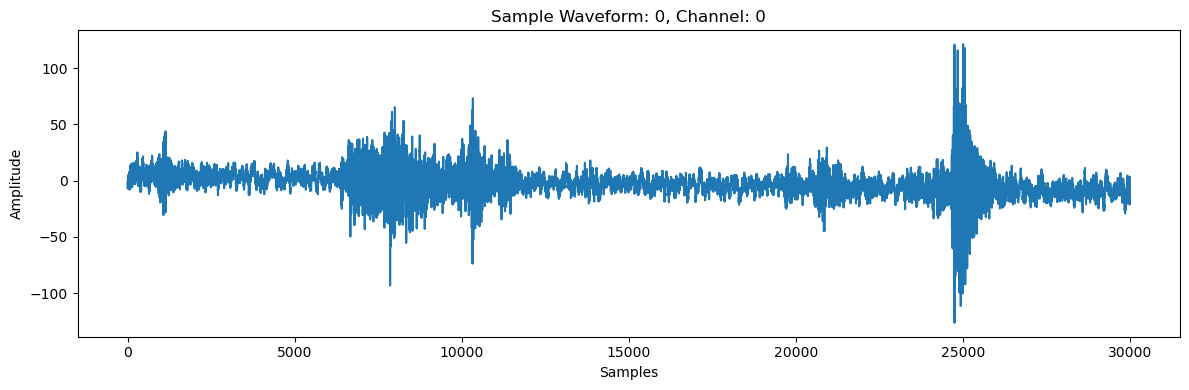

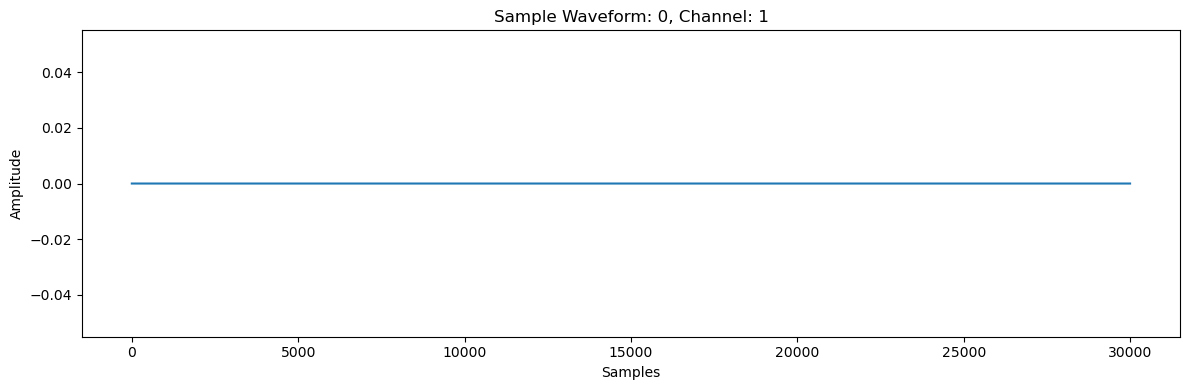

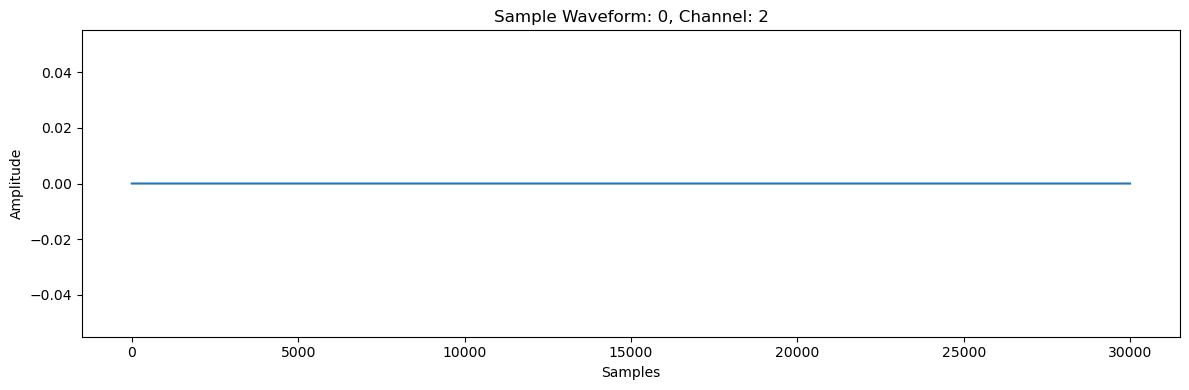

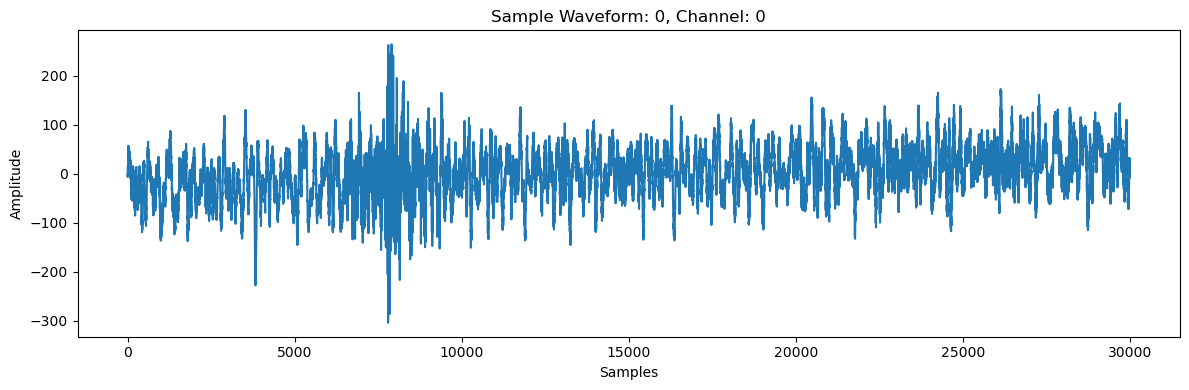

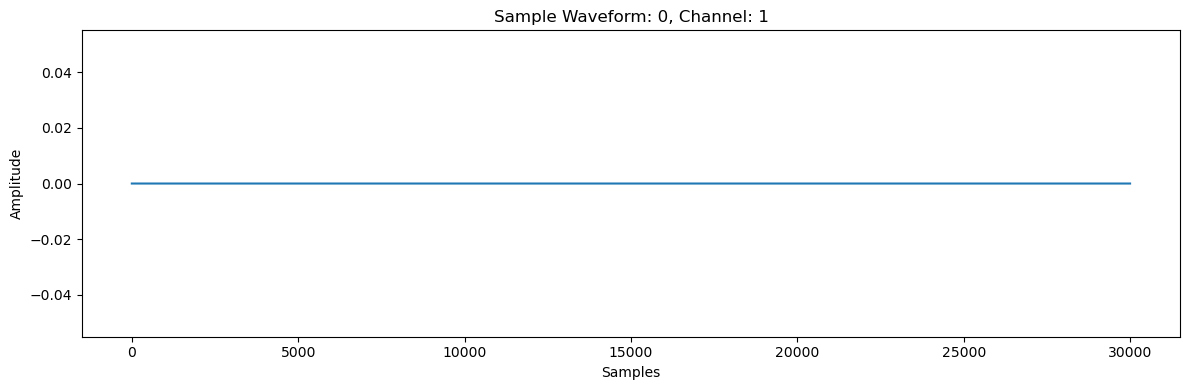

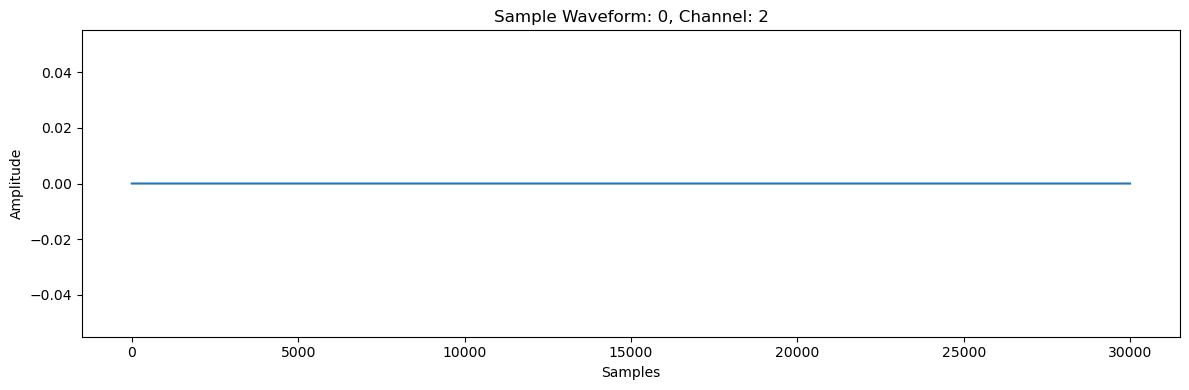

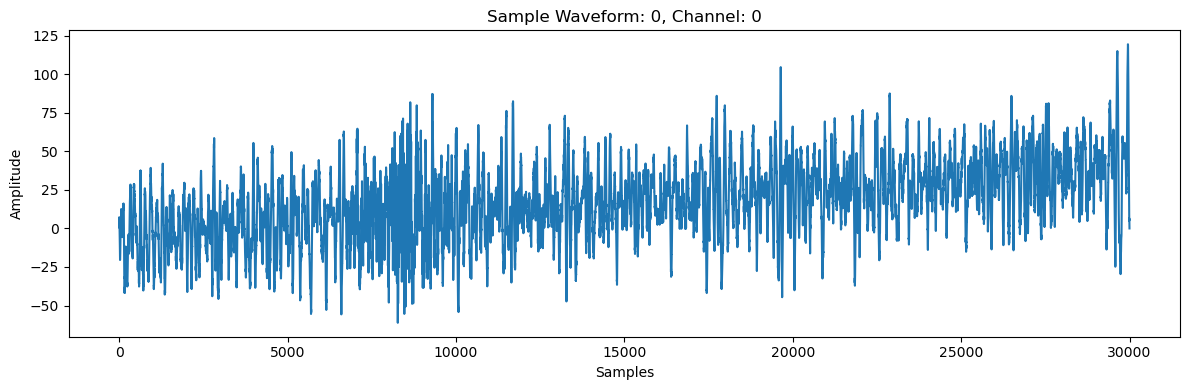

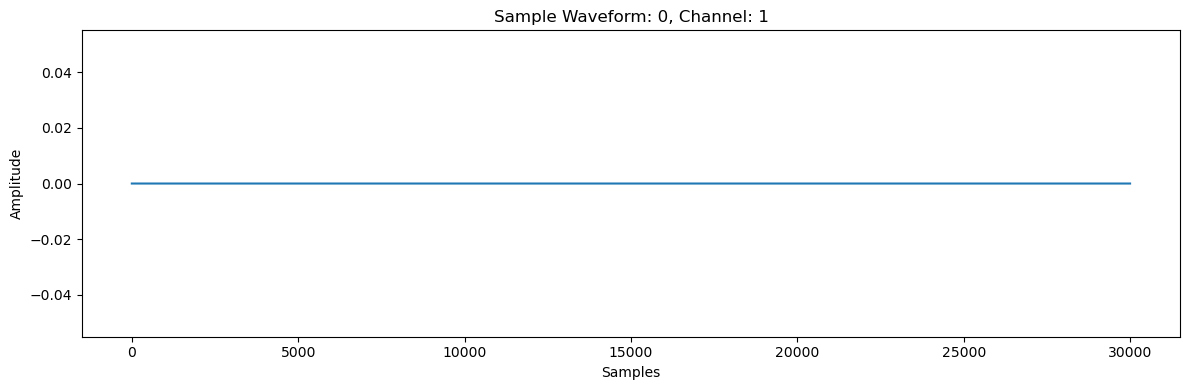

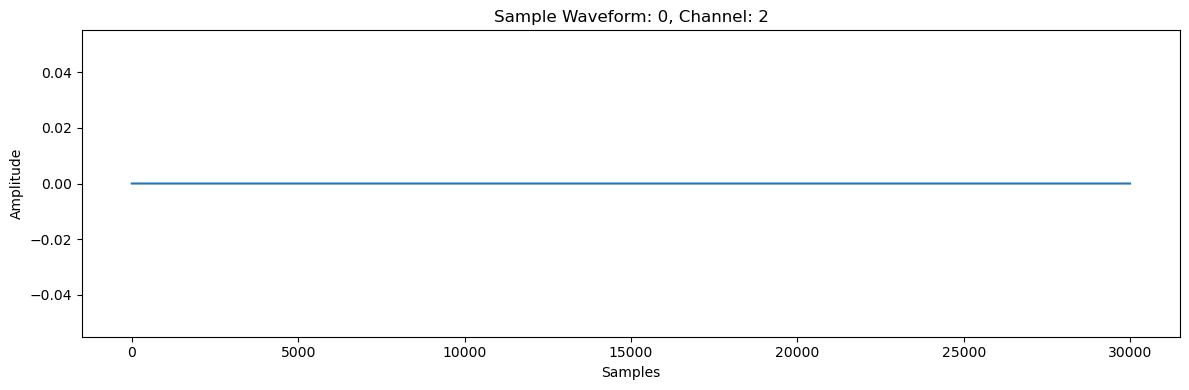

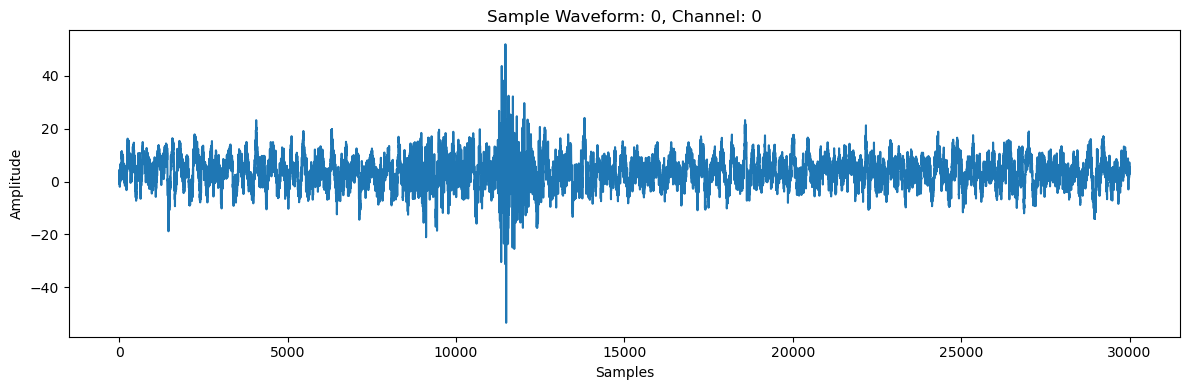

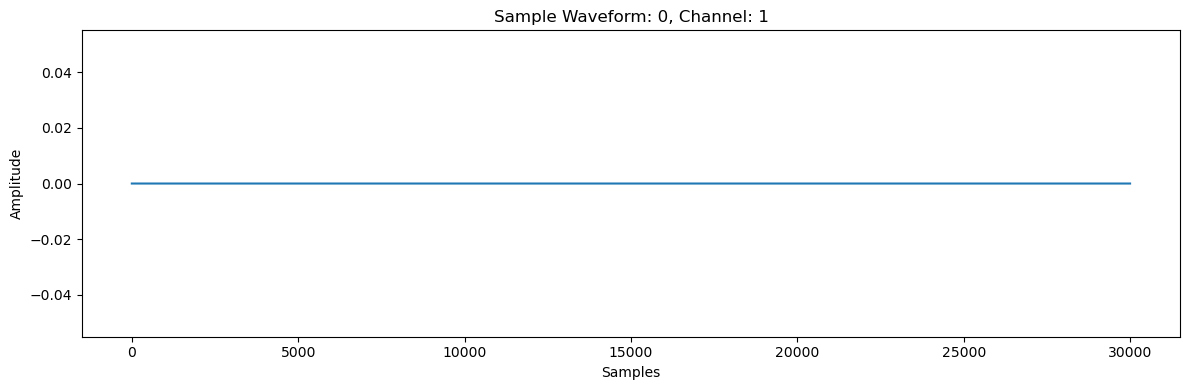

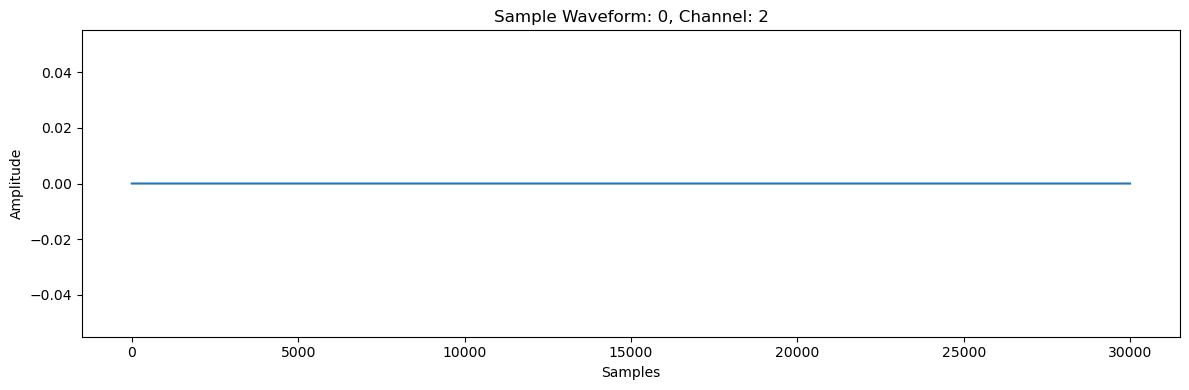

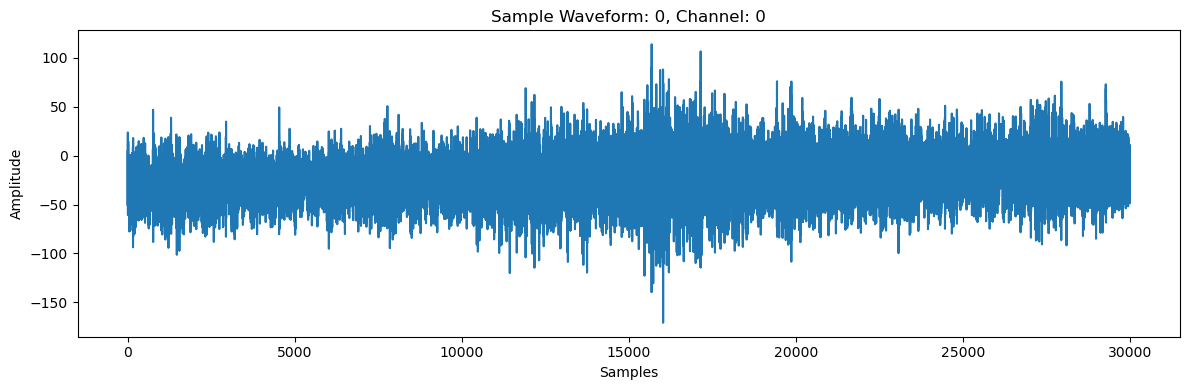

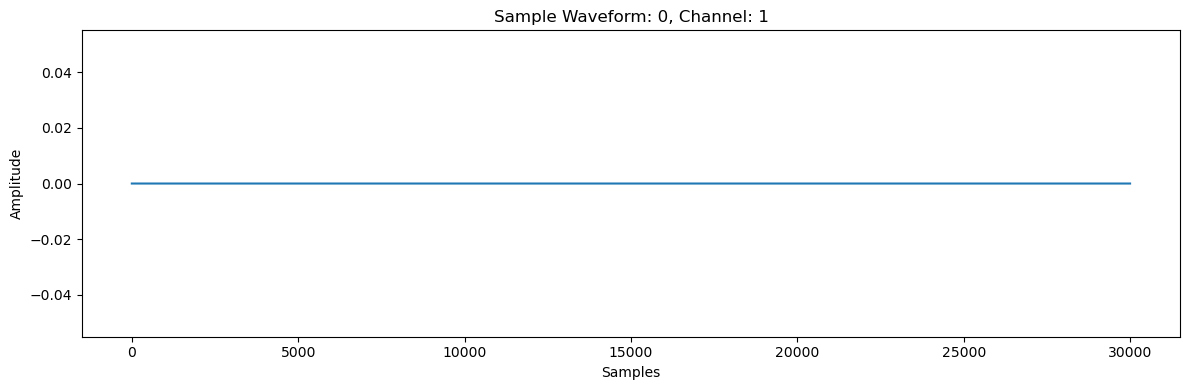

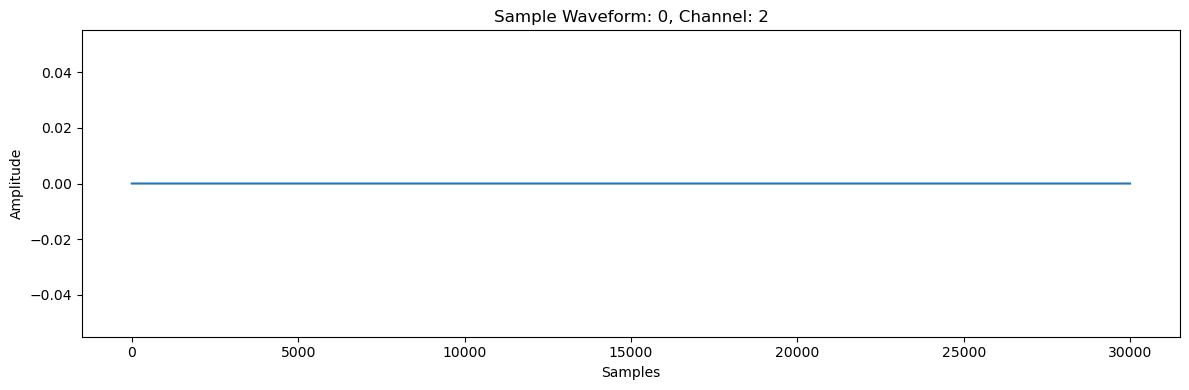

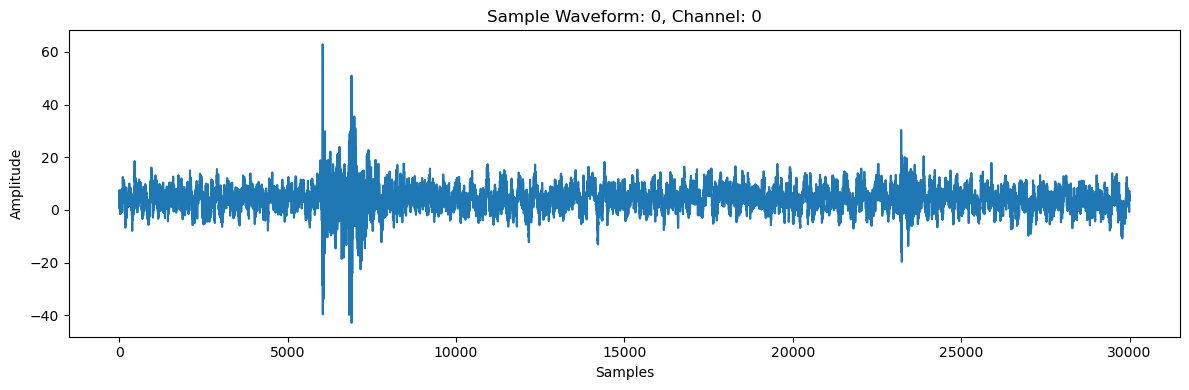

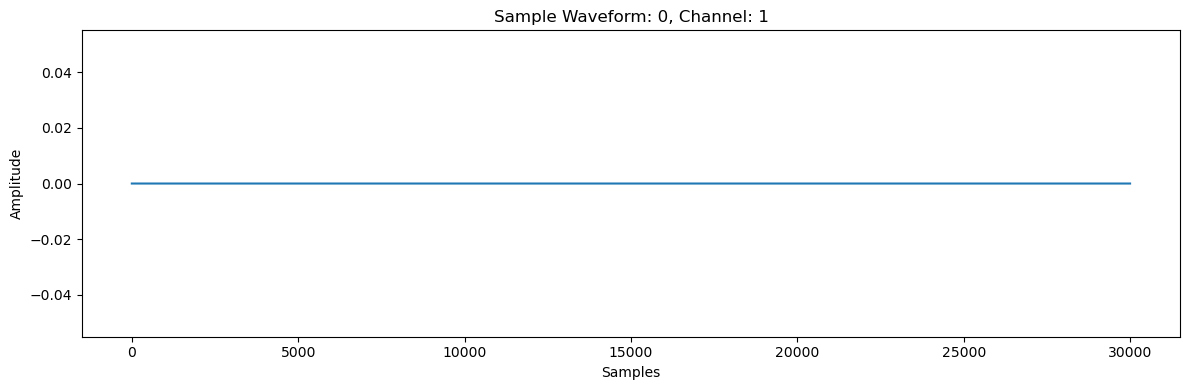

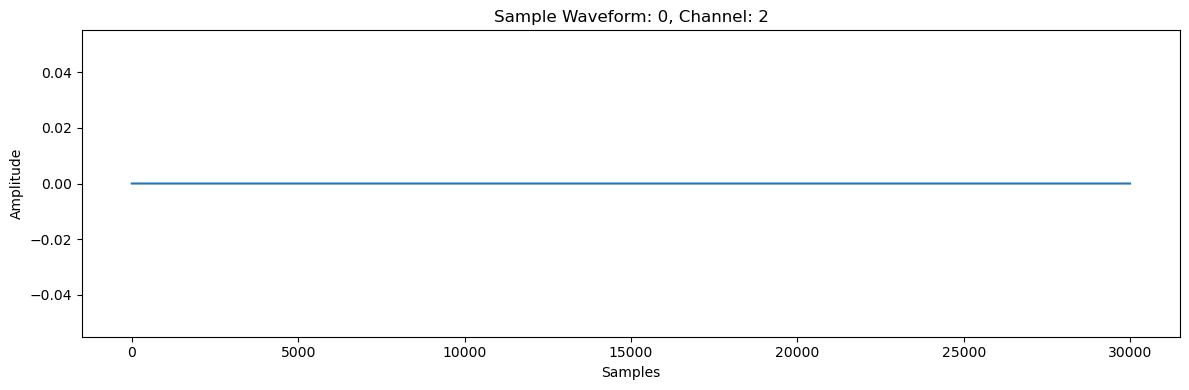

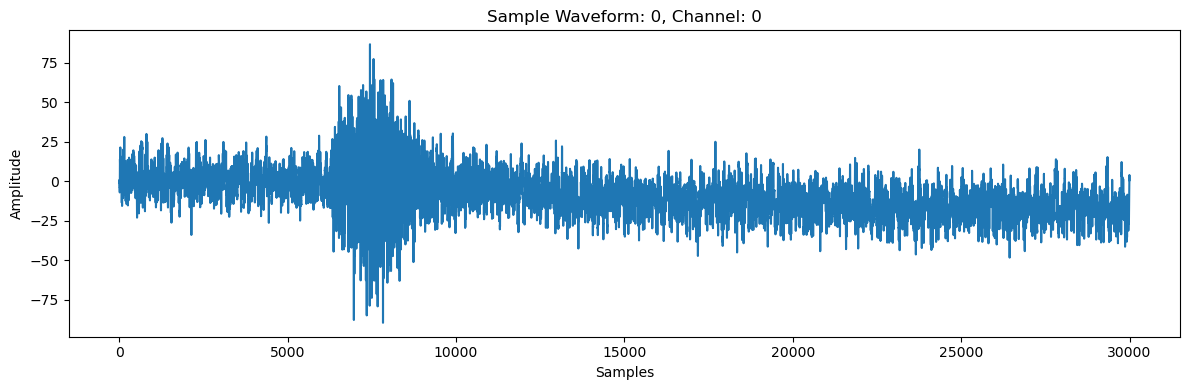

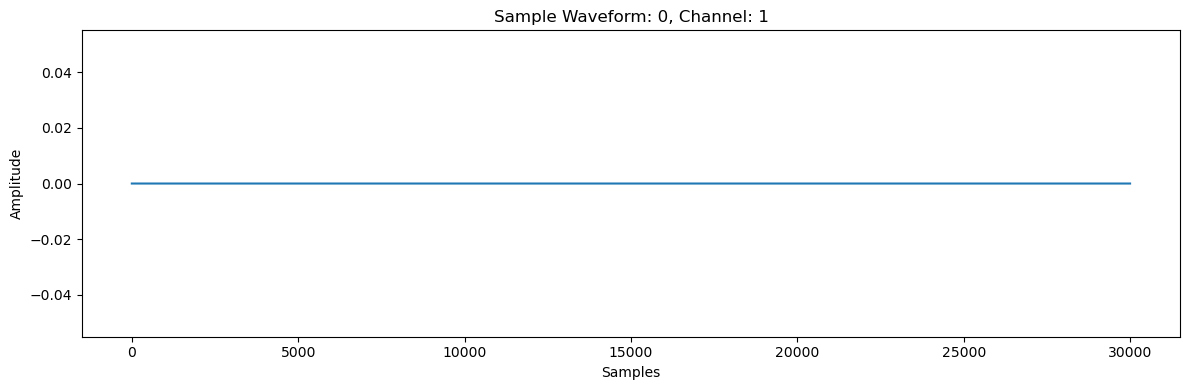

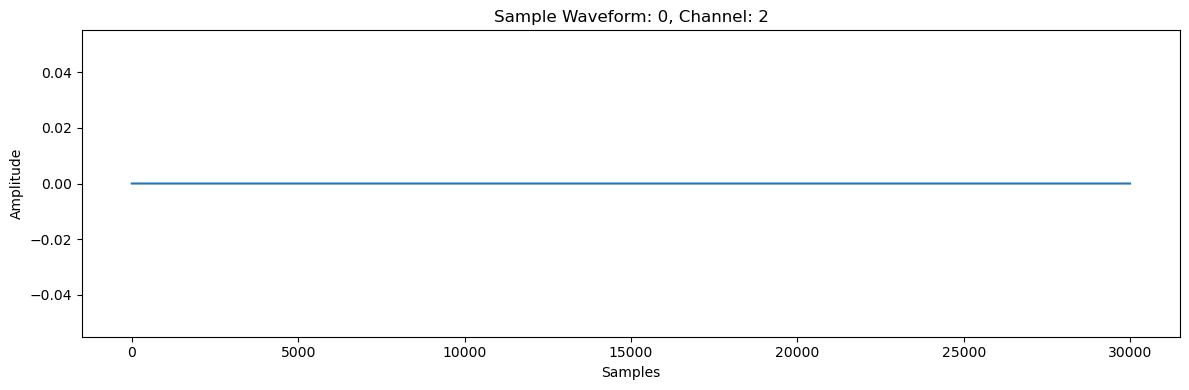

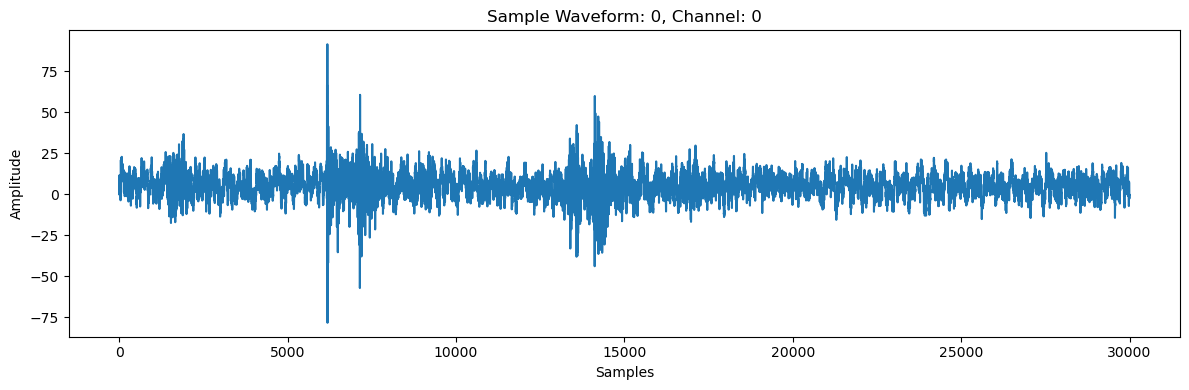

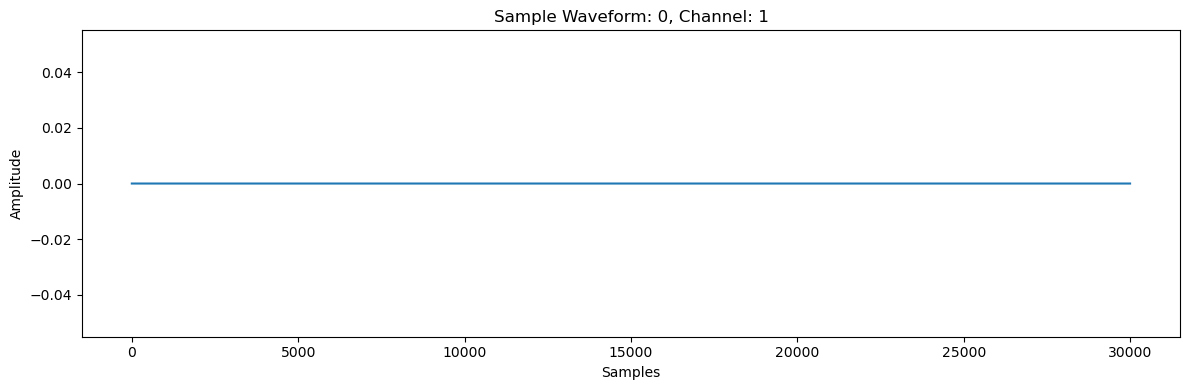

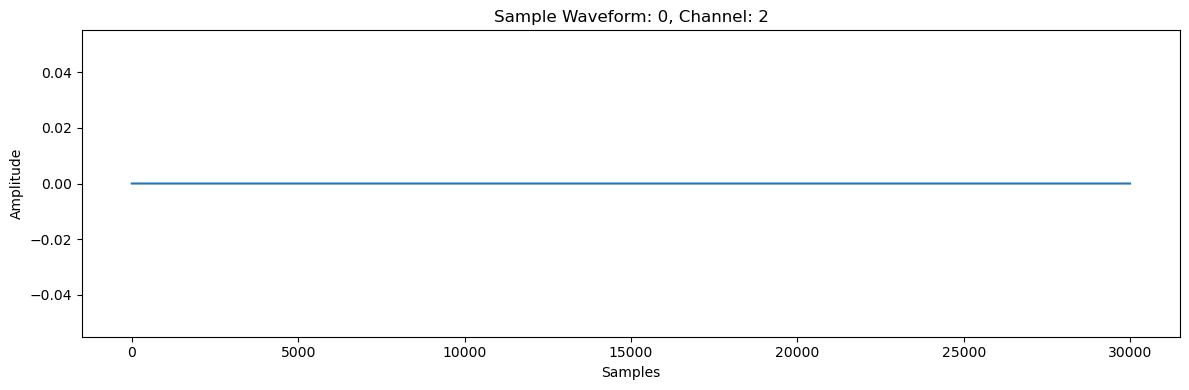

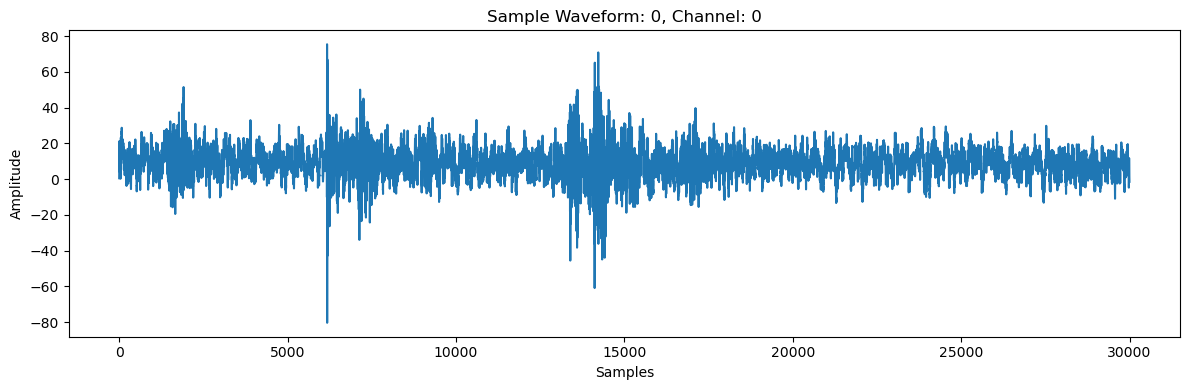

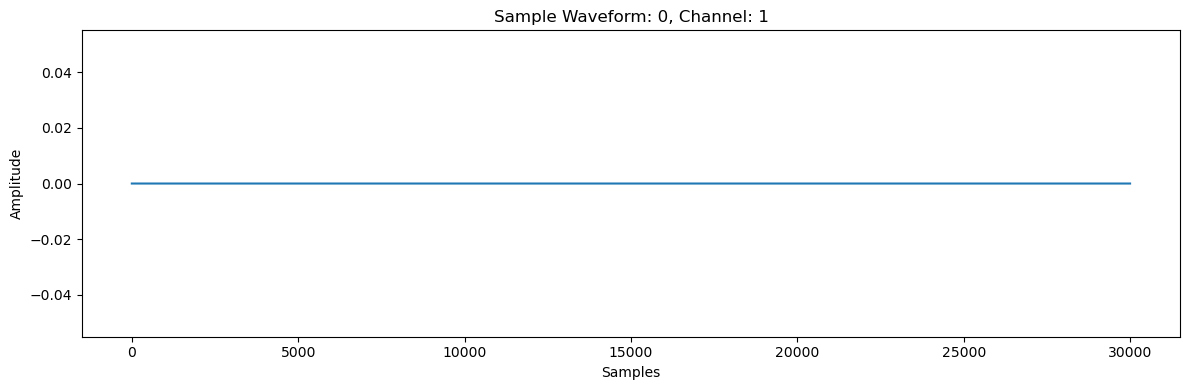

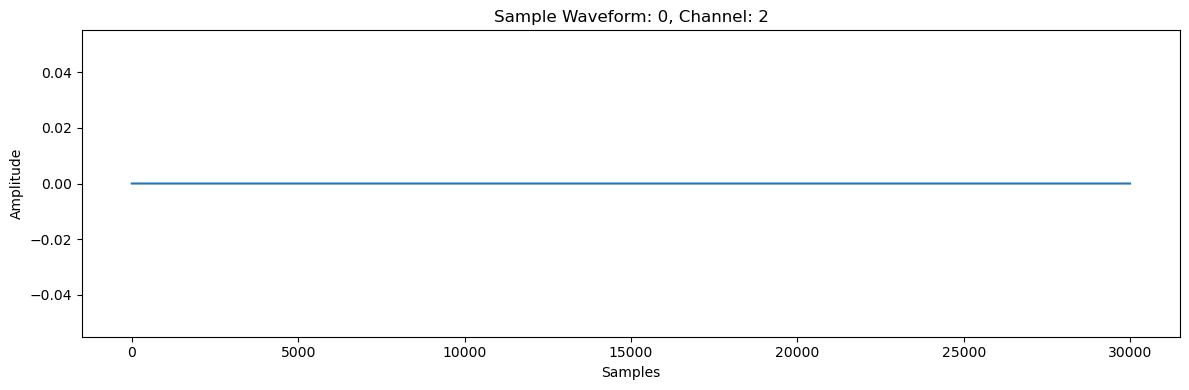

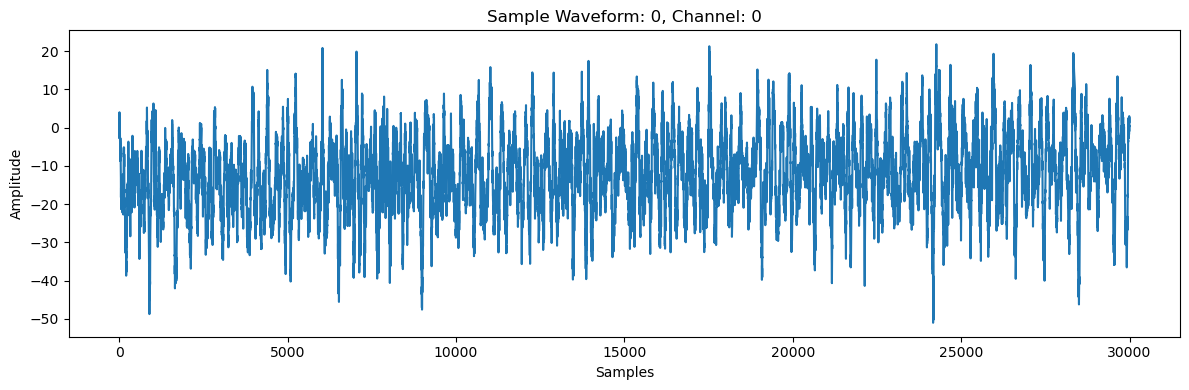

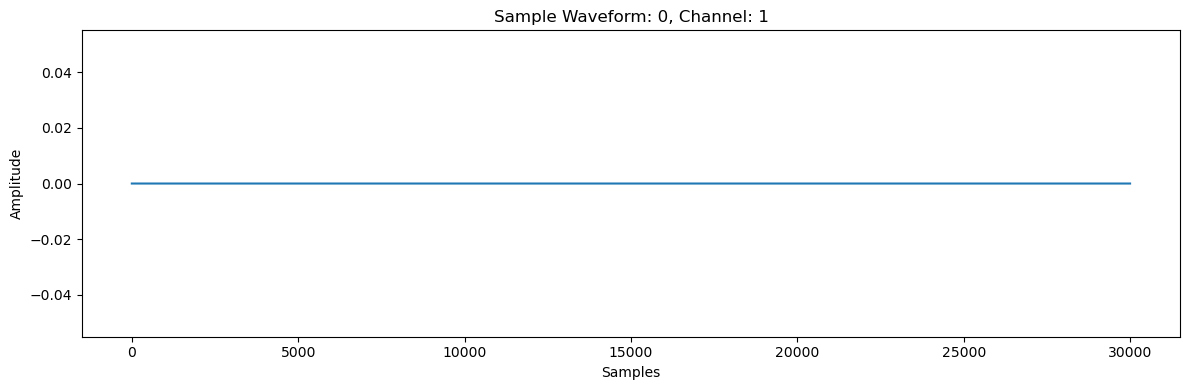

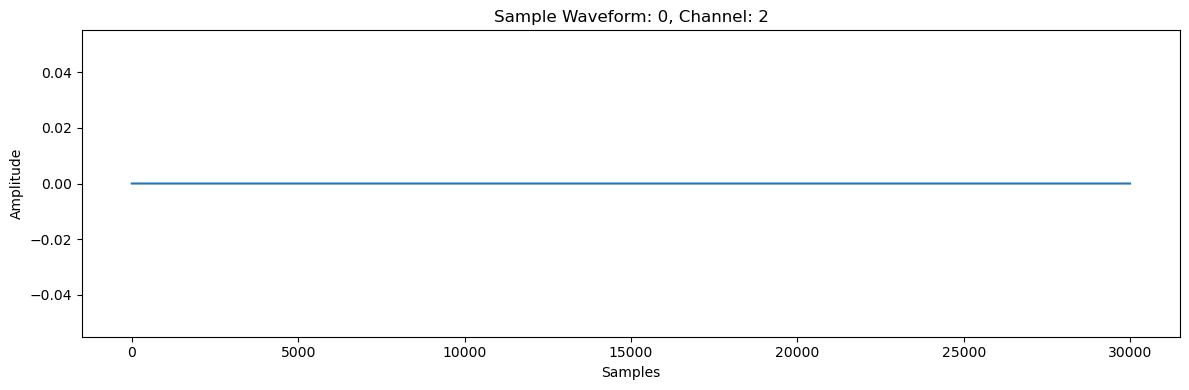

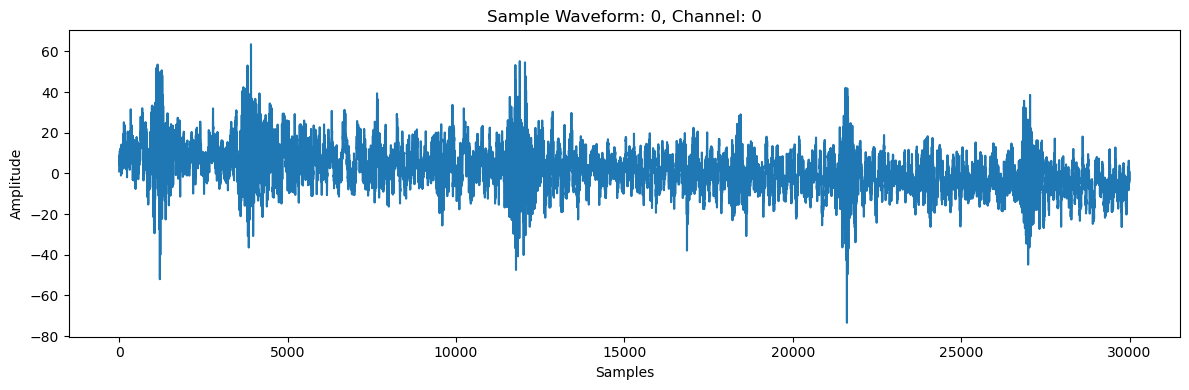

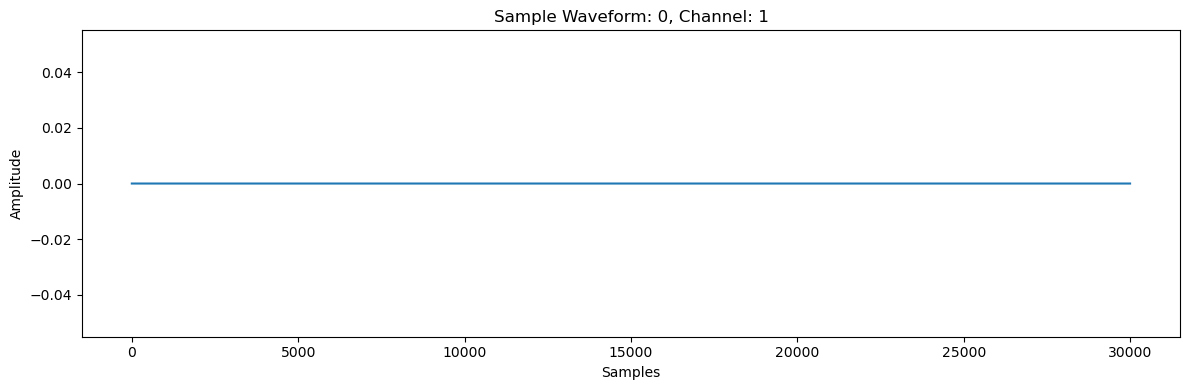

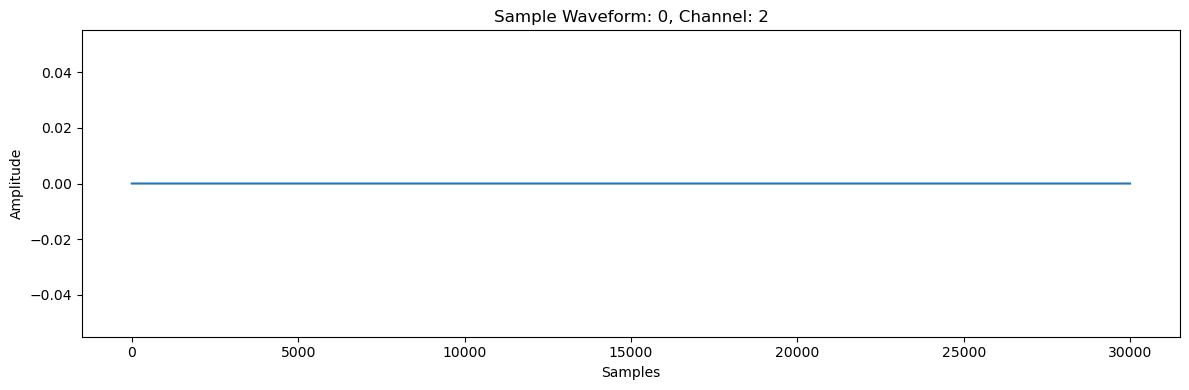

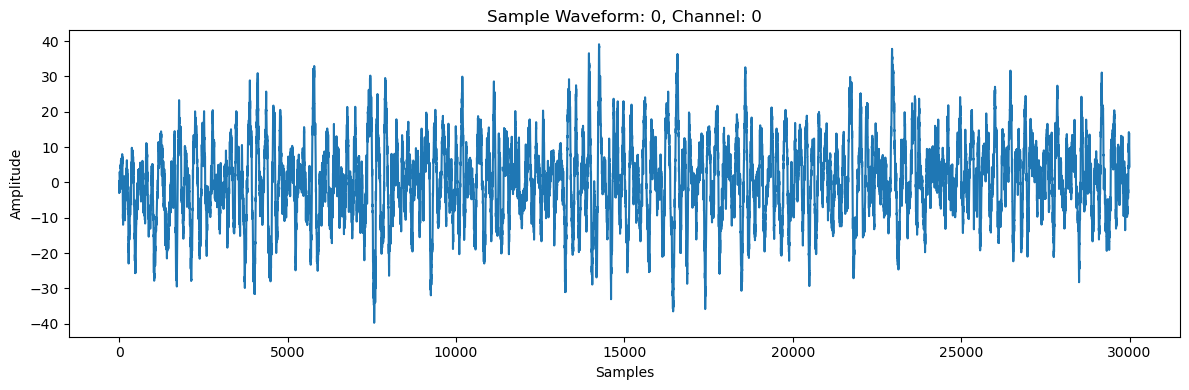

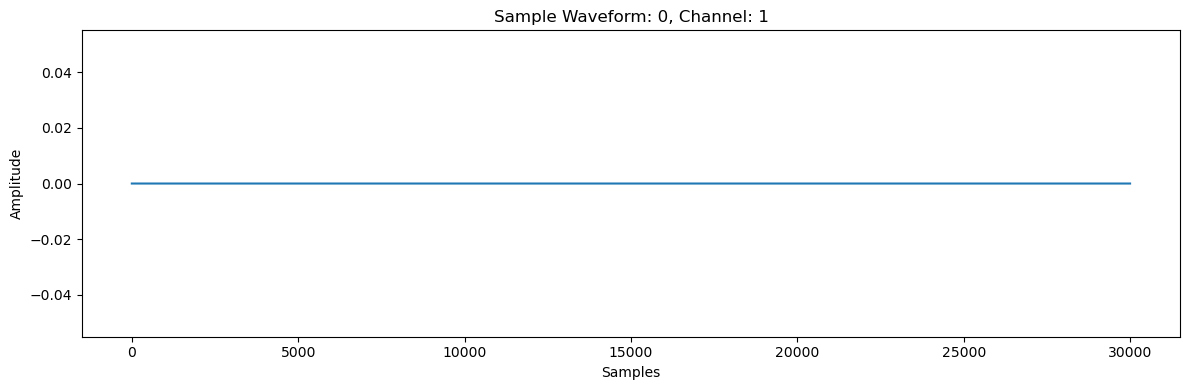

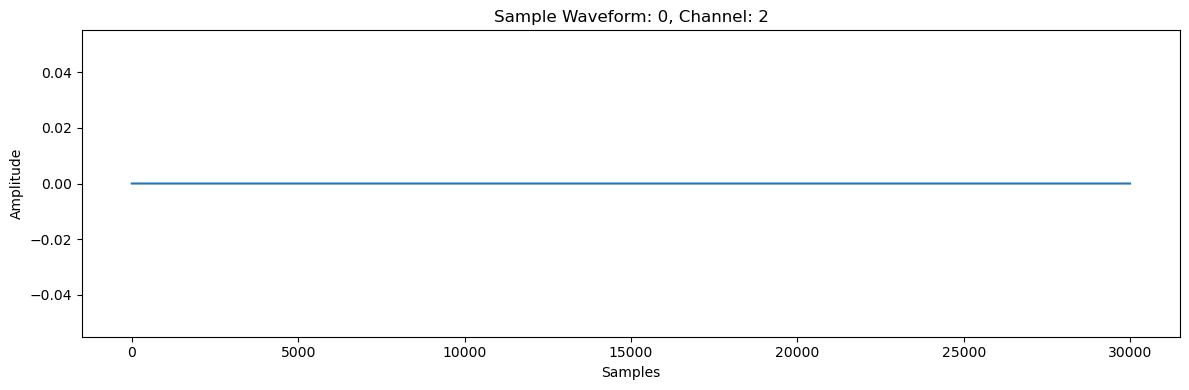

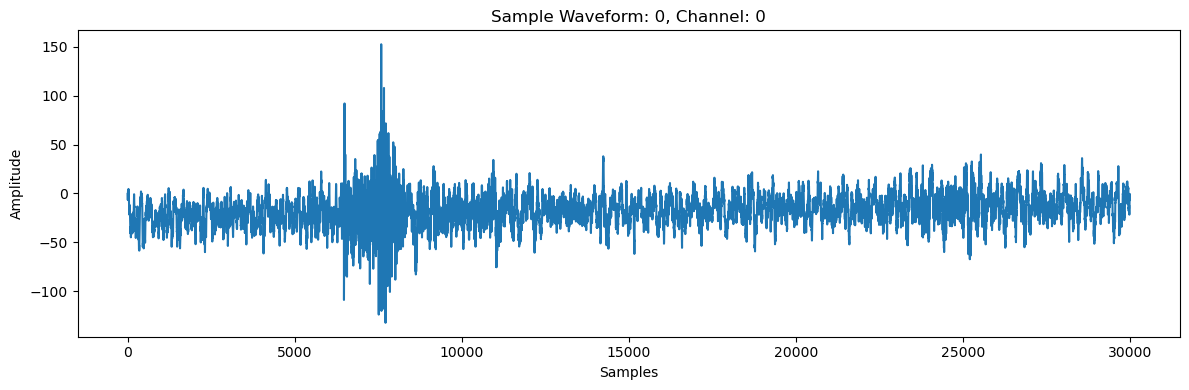

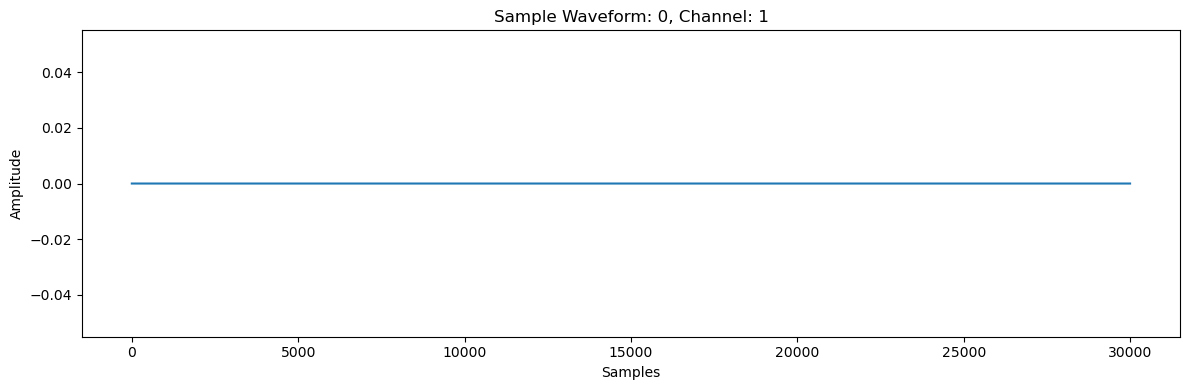

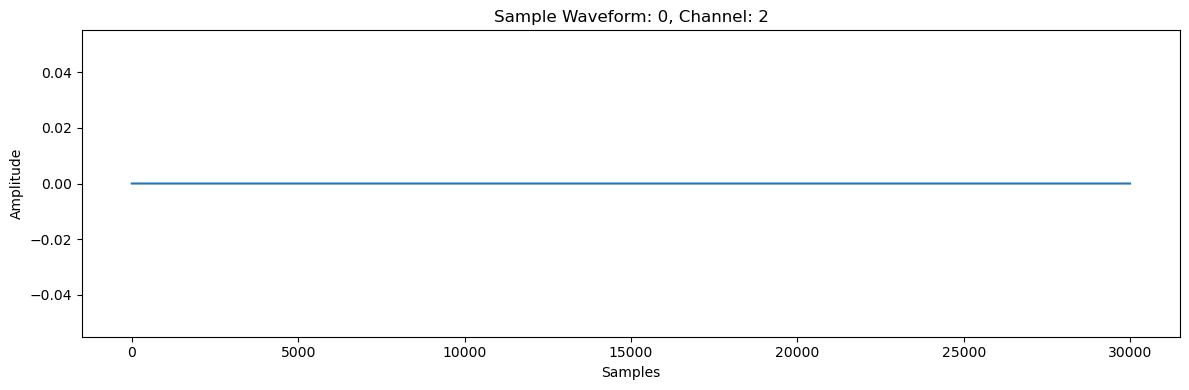

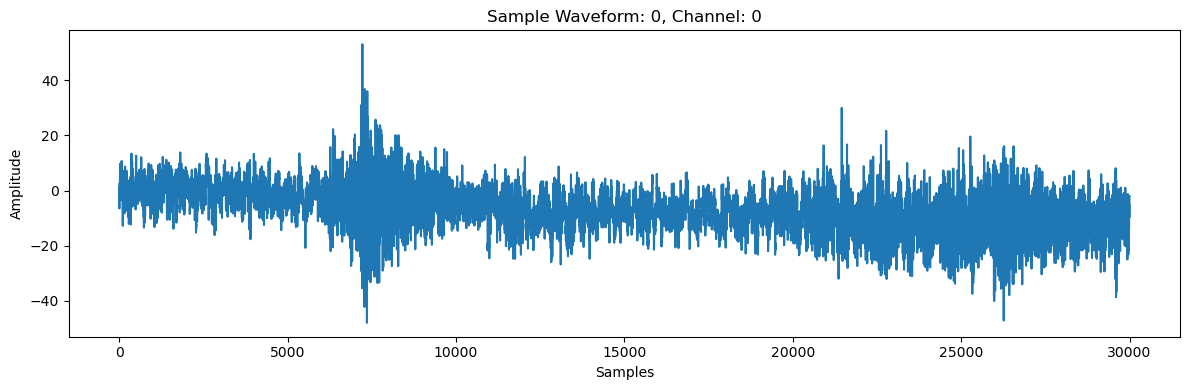

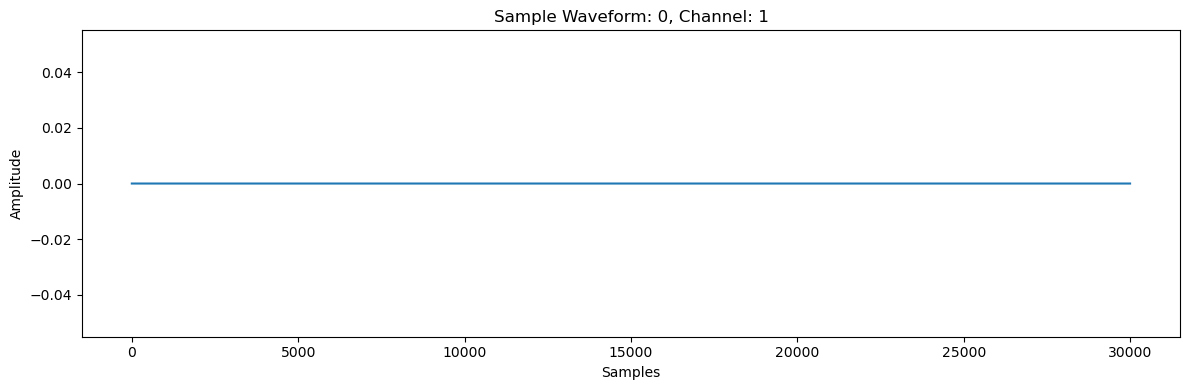

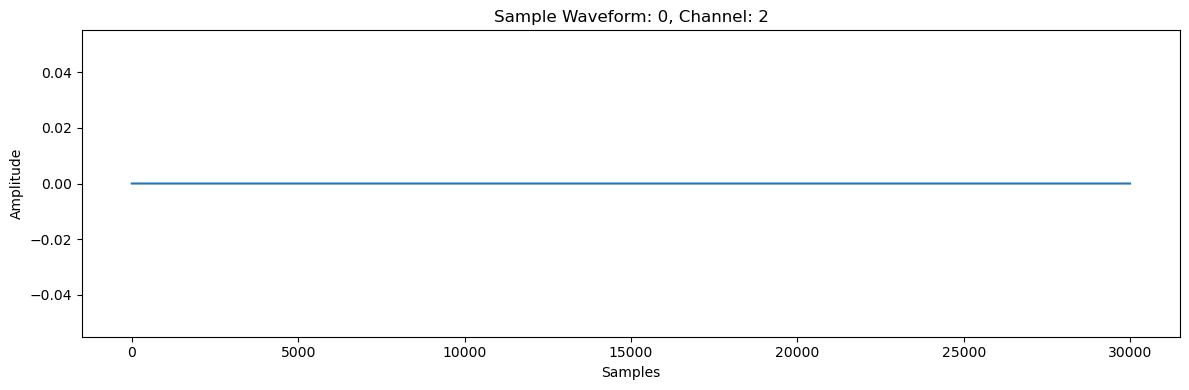

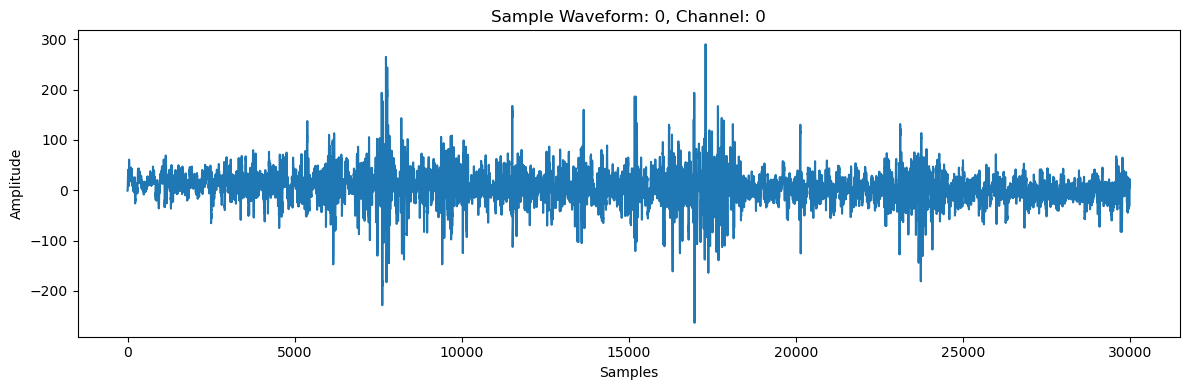

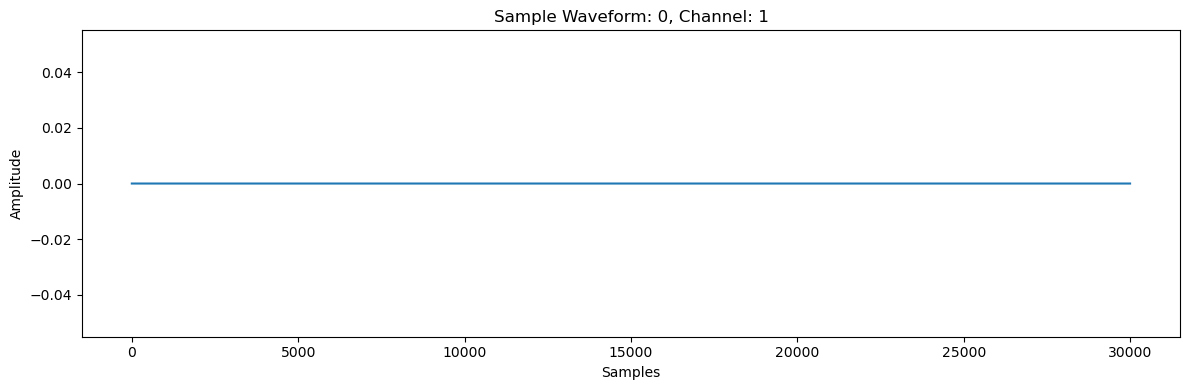

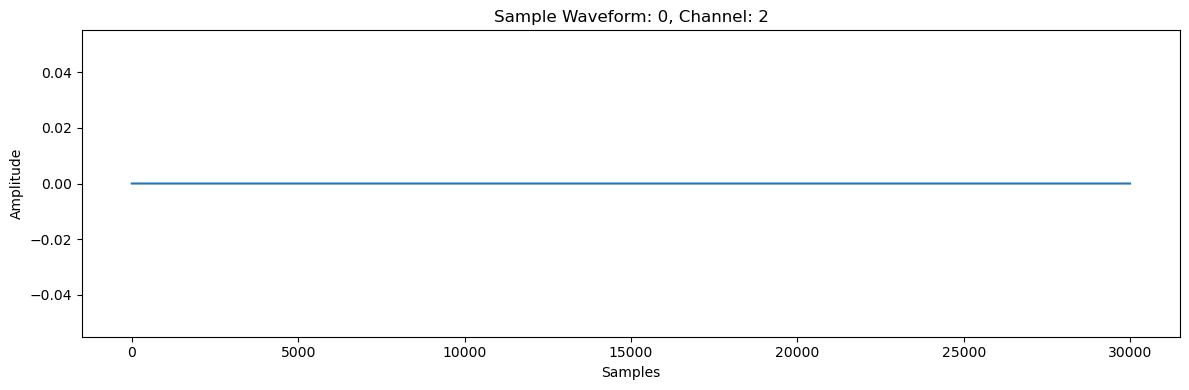

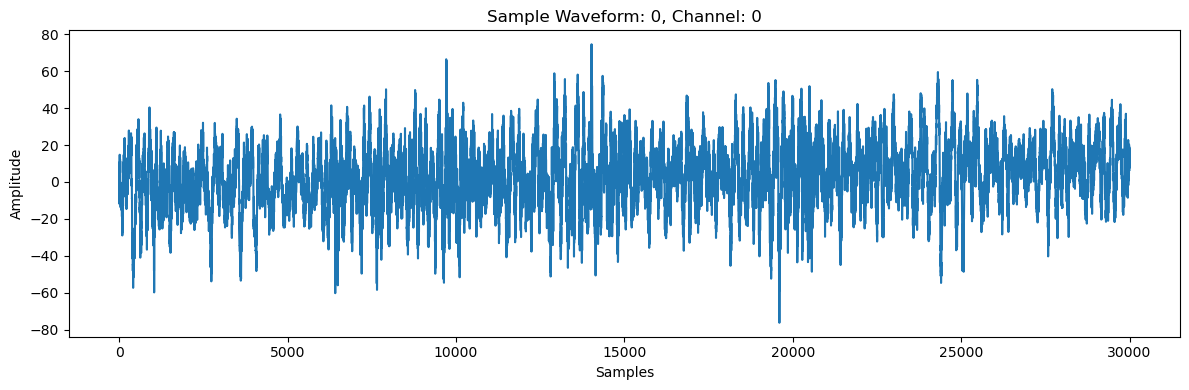

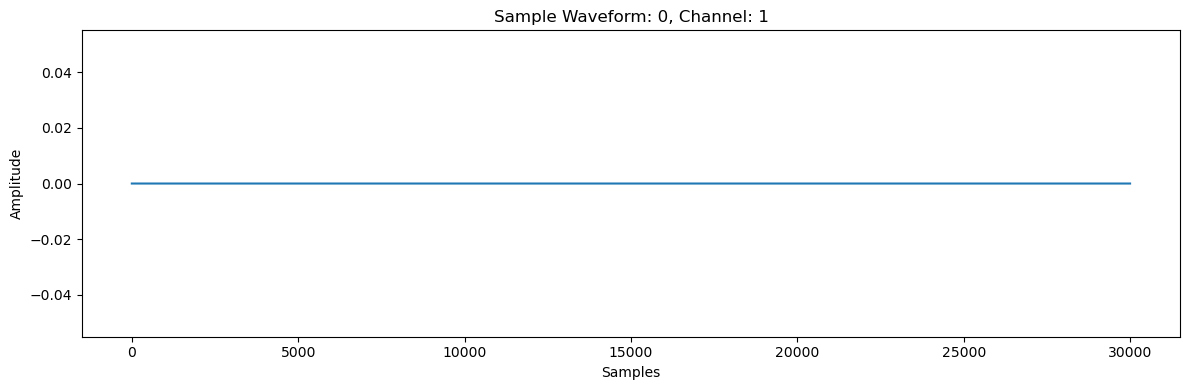

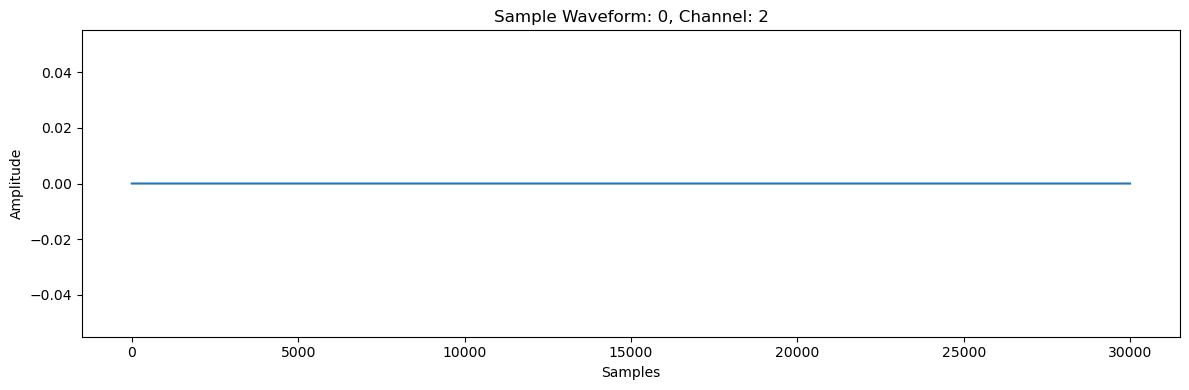

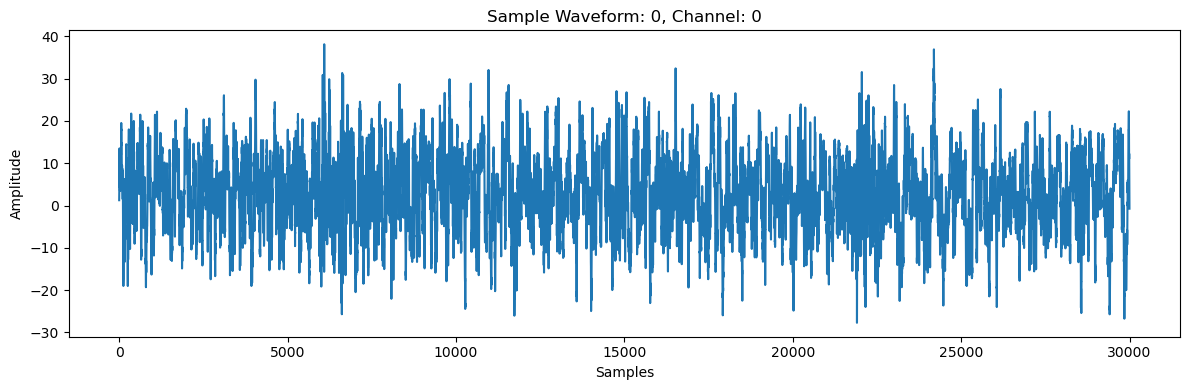

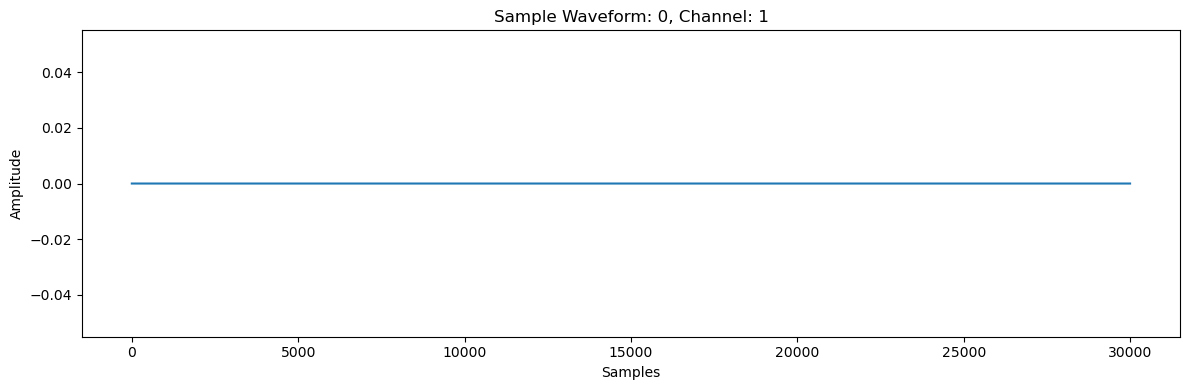

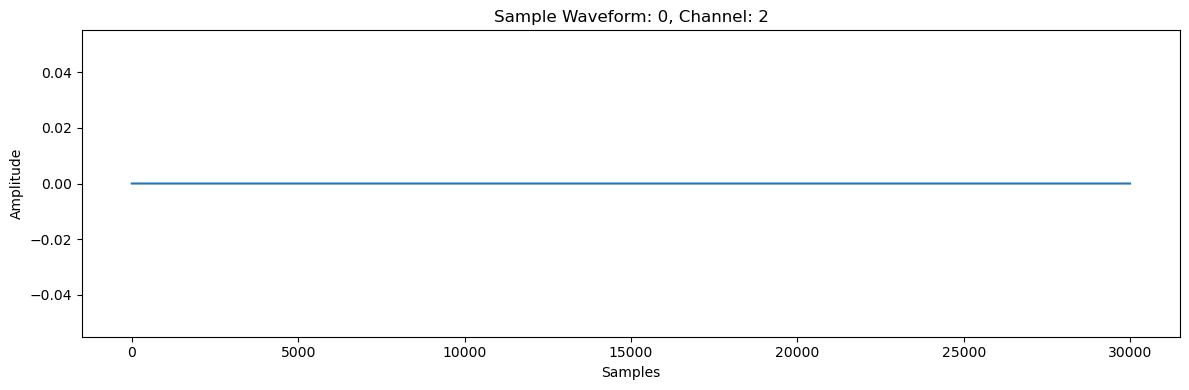

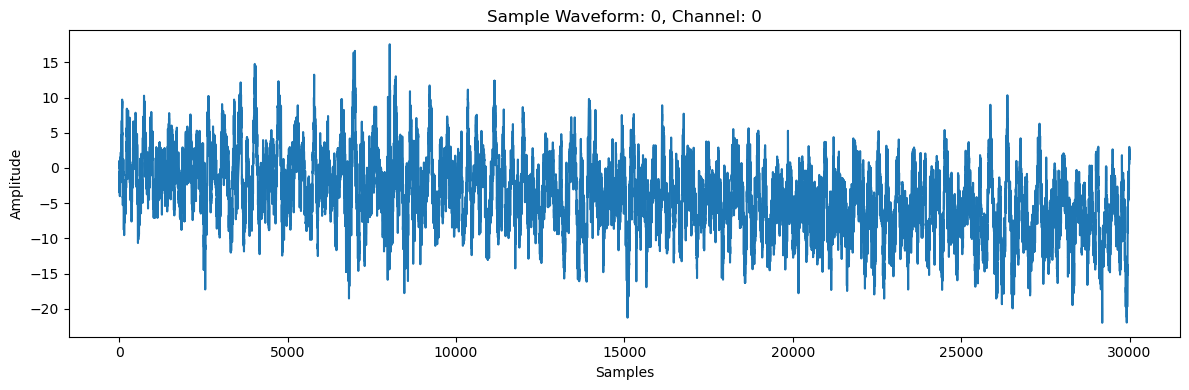

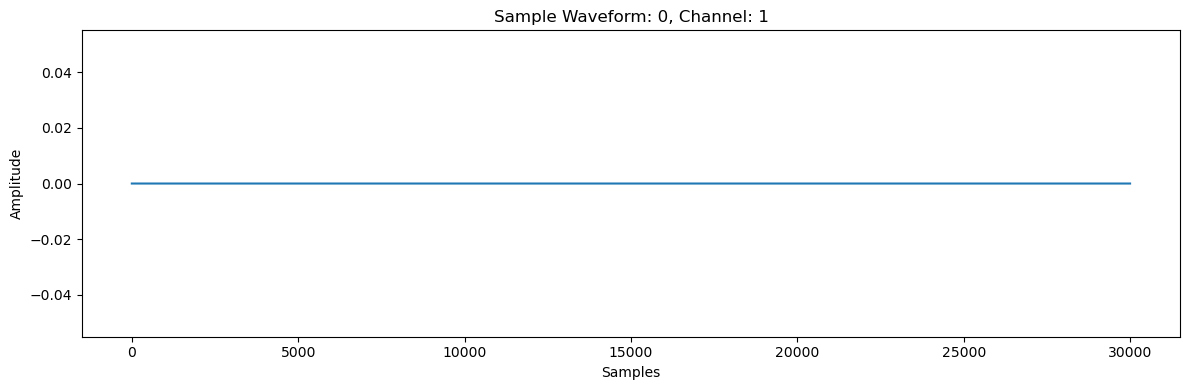

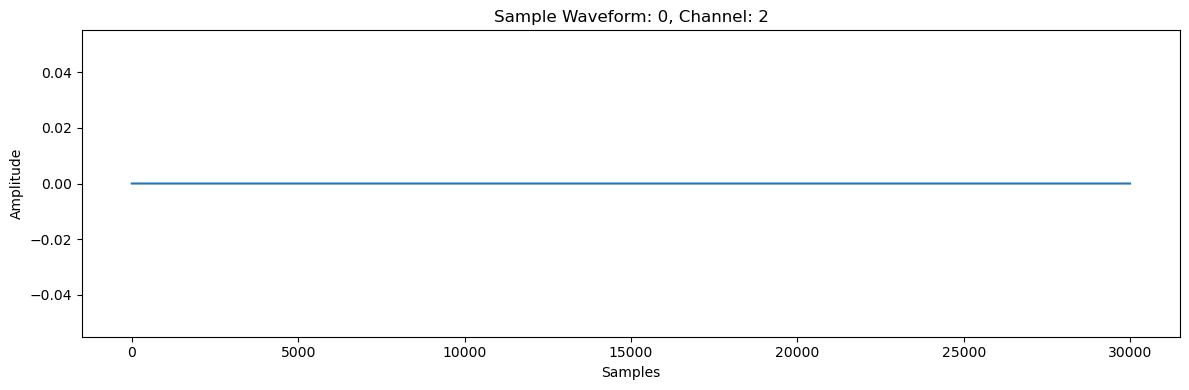

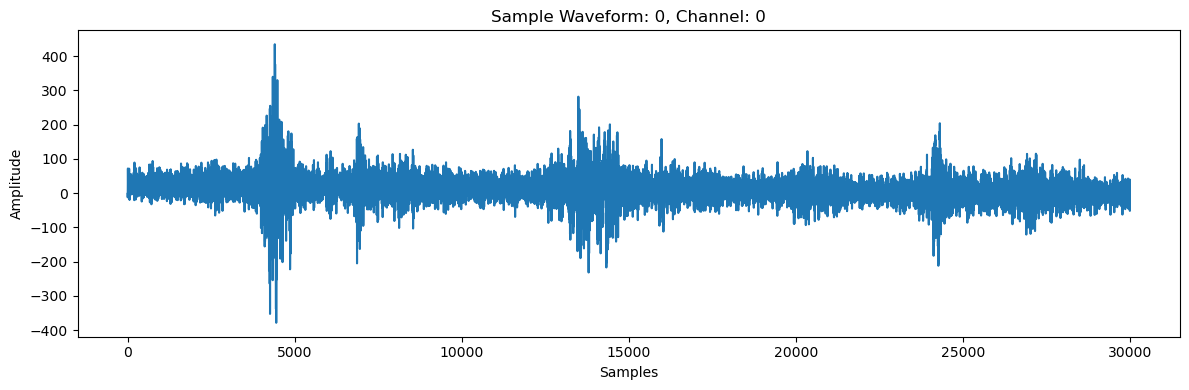

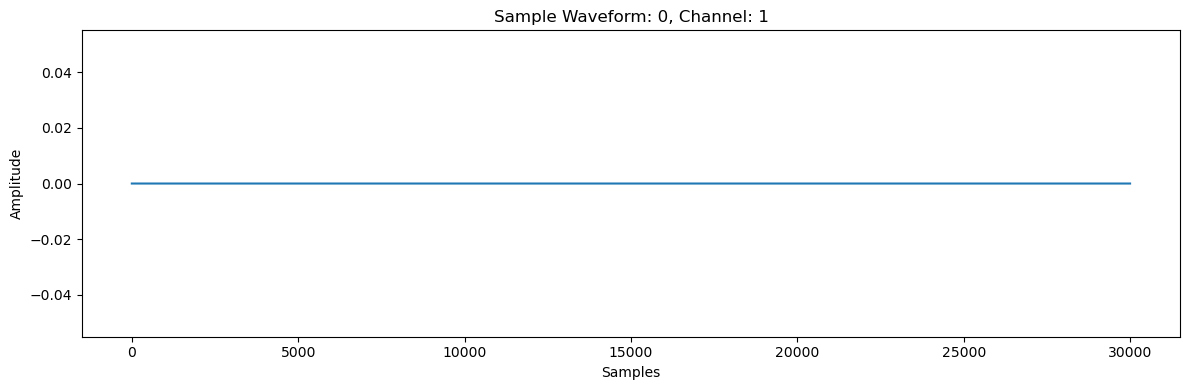

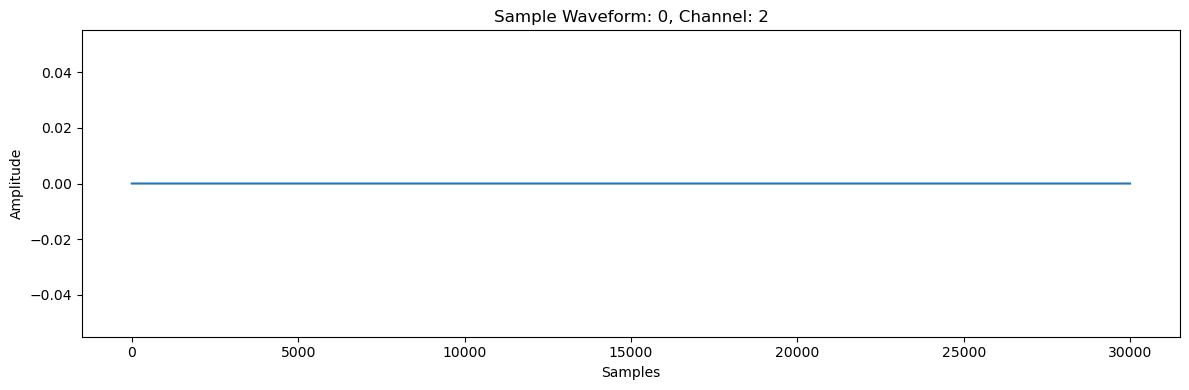

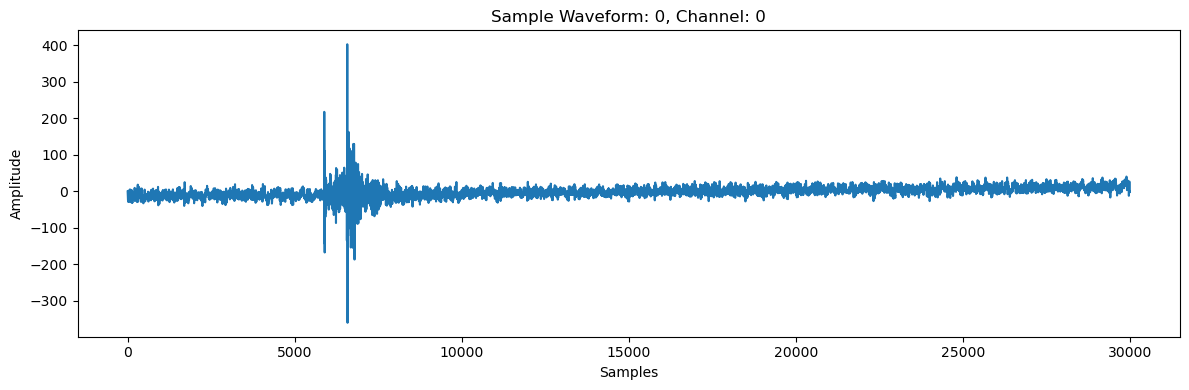

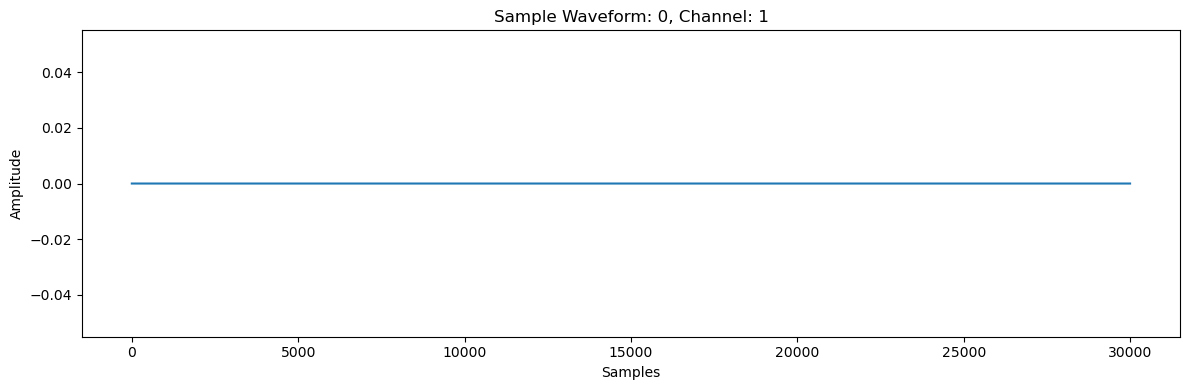

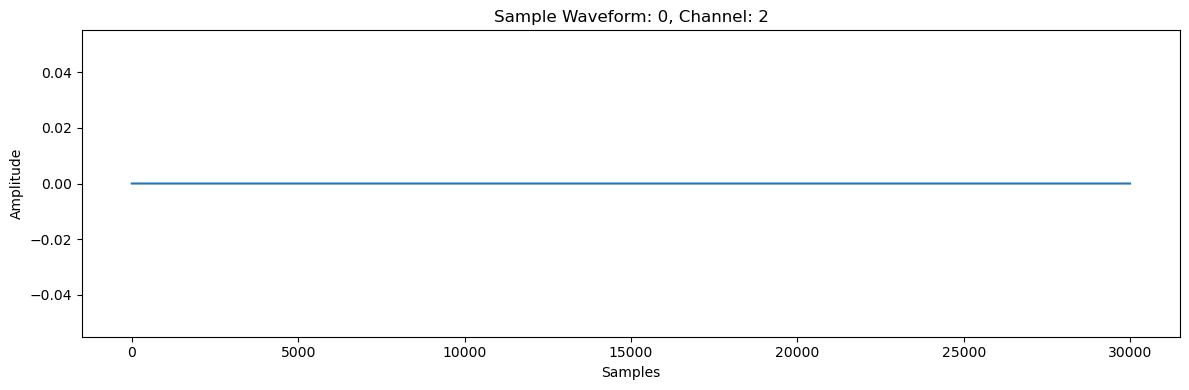

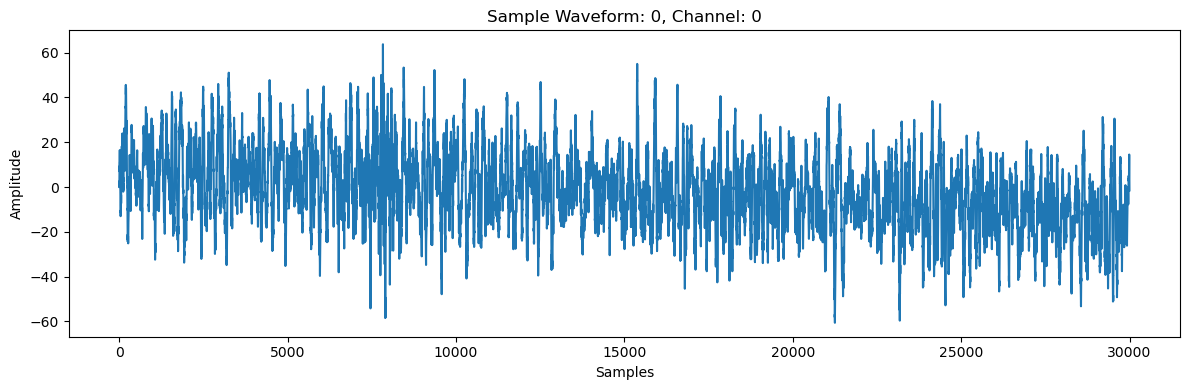

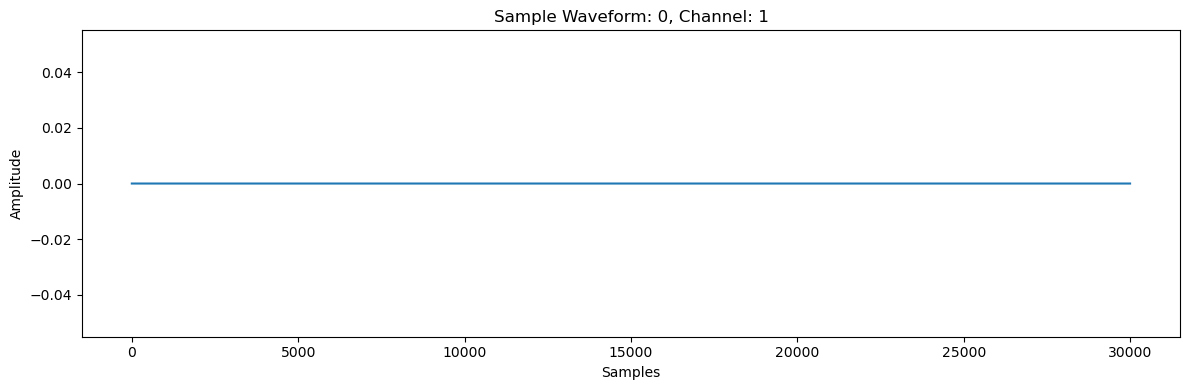

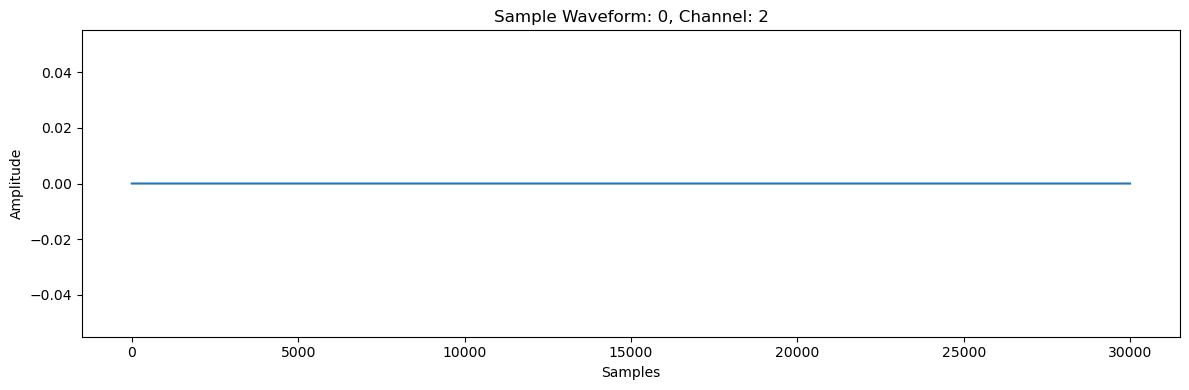

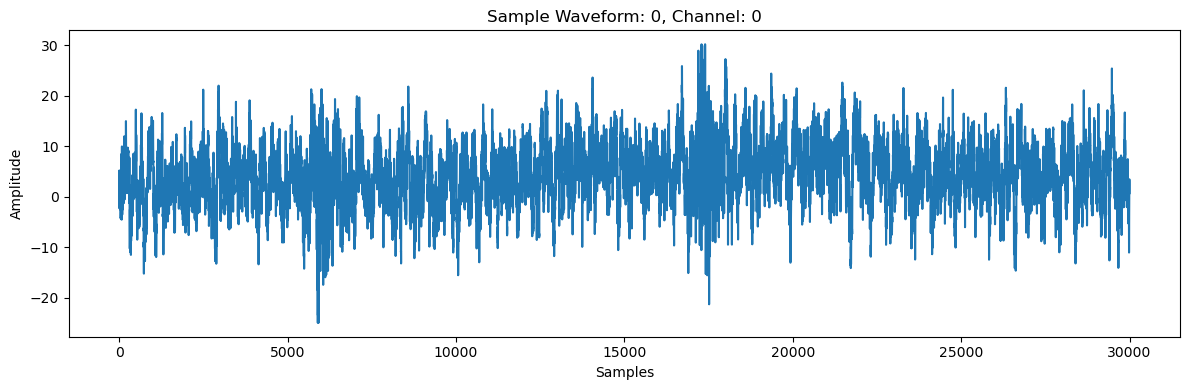

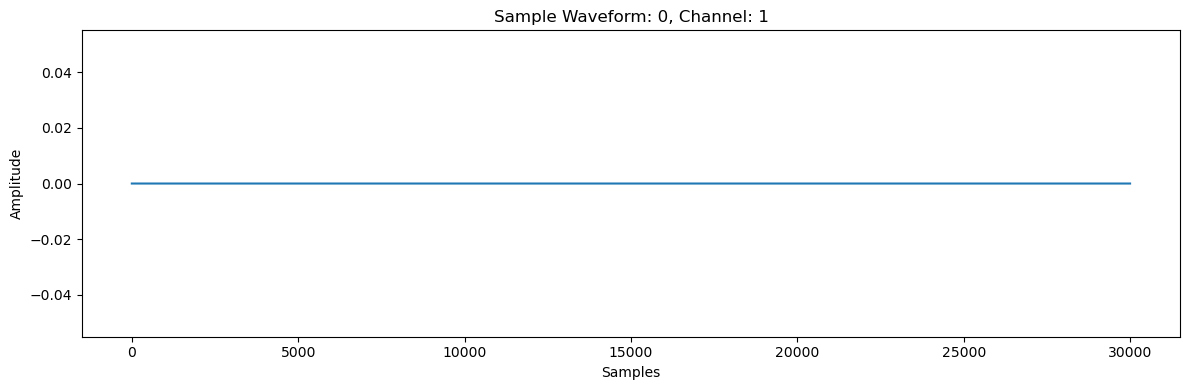

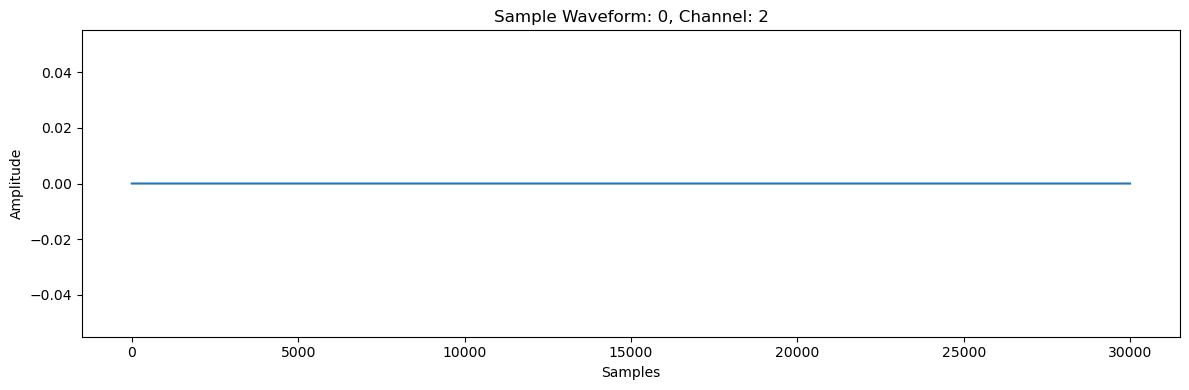

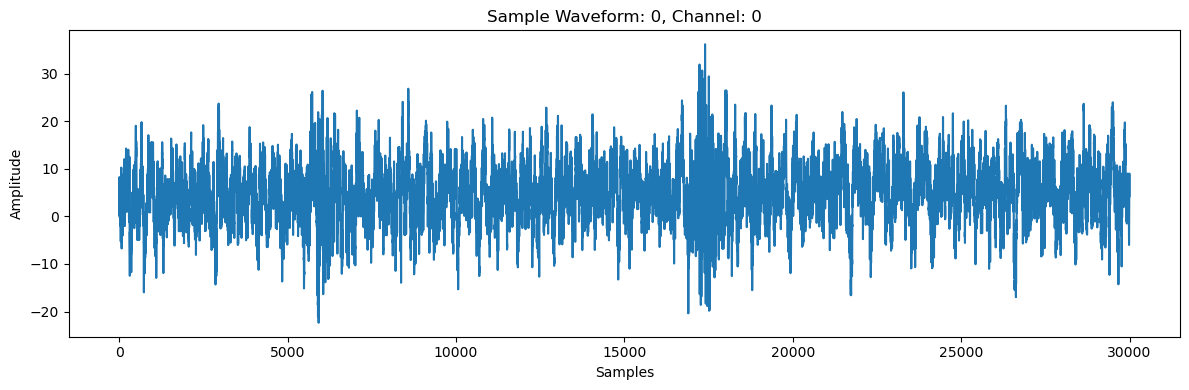

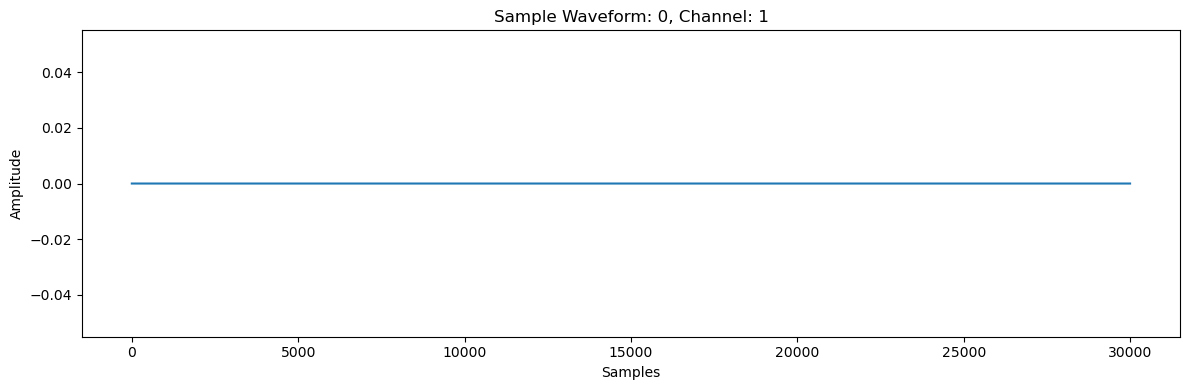

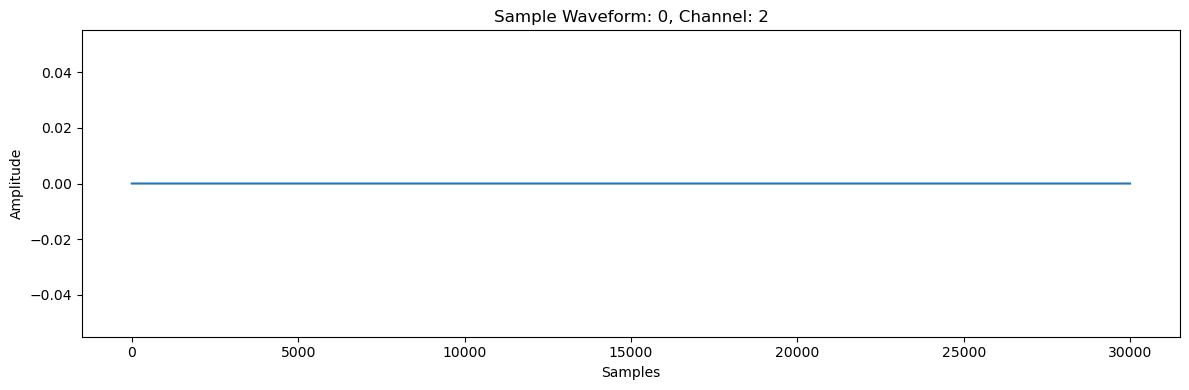

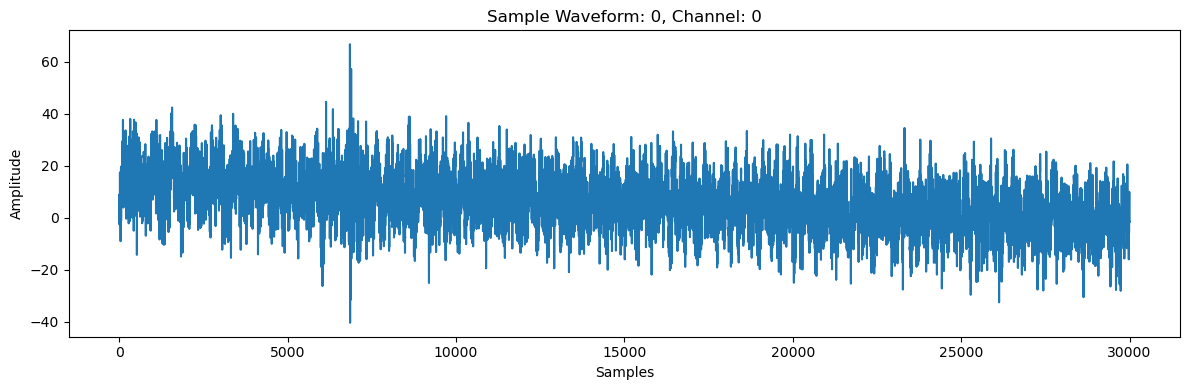

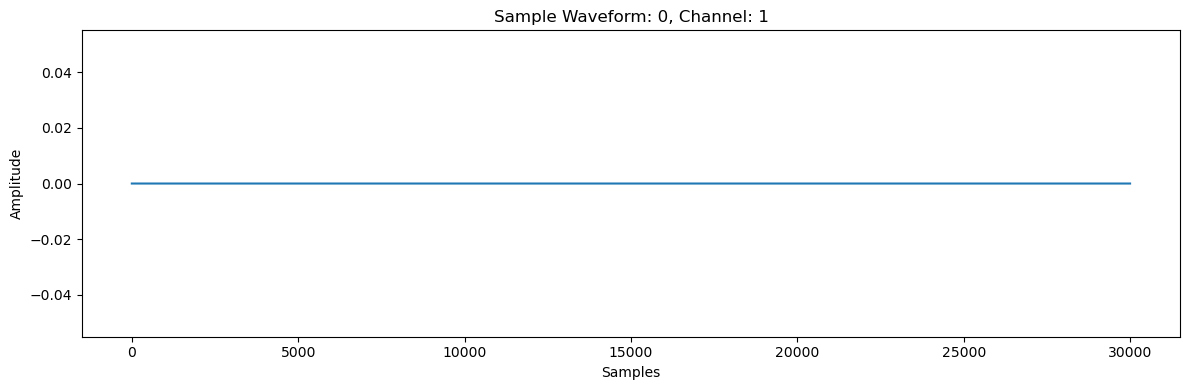

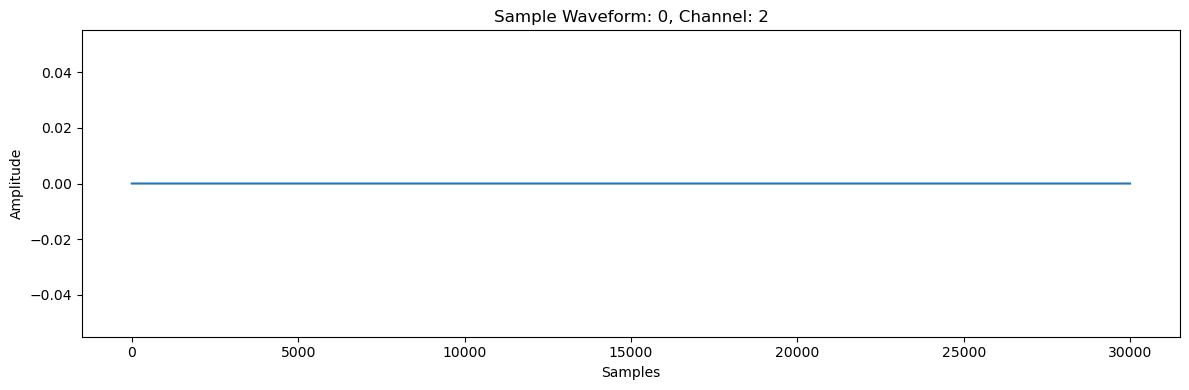

Total number of waveforms processed: 247


In [45]:
total_num_waveforms = 0
with h5py.File(output_waveform_file, 'r') as f:
    print("Keys in HDF5 file:")
    for key in f.keys():
        print(f" - {key}")
    print(f['data'].keys())

    waveforms_group = f['data']

    for i, key in enumerate(list(waveforms_group.keys())[:]):
                waveform = waveforms_group[key][:]
                print(f" - {key}: shape={waveform.shape}, min={waveform.min():.2f}, max={waveform.max():.2f}")
                total_num_waveforms += waveform.shape[0]

    # Plot a sample waveform if matplotlib is available
    if list(waveforms_group.keys()):
        sample_key = list(waveforms_group.keys())[0]
        sample_waveform = waveforms_group[sample_key][:]

        print('samplewaveform shape:', sample_waveform[0].shape)
        for k in range(len(sample_waveform)):
            for j in range(len(sample_waveform[k])):
                plt.figure(figsize=(12, 4))
                y = sample_waveform[k,j,:]
                x = np.arange(len(y))
                plt.plot(x, y)
                plt.title(f"Sample Waveform: {sample_key}, Channel: {j}")
                plt.xlabel("Samples")
                plt.ylabel("Amplitude")
                plt.tight_layout()
                plt.show()
        

print(f"Total number of waveforms processed: {total_num_waveforms}")
    

In [32]:
sample_waveform.shape

(24, 3, 30000)

In [34]:
sample_waveform[0,:,:].shape

(3, 30000)

In [27]:
metadata = pd.read_csv(output_metadata_file)
metadata.iloc[0:10][['event_id','source_origin_time','source_latitude_deg','source_longitude_deg','source_depth_km','station_network_code','station_channel_code','station_code','station_latitude_deg','station_longitude_deg','trace_name','trace_P_arrival_sample', 'trace_S_arrival_sample','trace_P_onset','trace_S_onset','trace_start_time']]

,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,station_network_code,station_channel_code,station_code,station_latitude_deg,station_longitude_deg,trace_name,trace_P_arrival_sample,trace_S_arrival_sample,trace_P_onset,trace_S_onset,trace_start_time
0,ev1262304917_262282,1.262305e+09,47.22533,-122.16895,56.111,UW,EH,PCMD,NaN,NaN,"5$0,:3,:30000",5991.0,6601.0,impulsive,impulsive,2010-01-01T00:14:27.262282Z
1,ev1262304917_262282,1.262305e+09,47.22533,-122.16895,56.111,UW,EH,RVW,NaN,NaN,"1$0,:3,:30000",7057.0,NaN,impulsive,NaN,2010-01-01T00:14:27.262282Z
2,ev1262304917_262282,1.262305e+09,47.22533,-122.16895,56.111,PB,EH,B013,NaN,NaN,"1$1,:3,:30000",NaN,7635.0,NaN,impulsive,2010-01-01T00:14:27.262282Z
3,ev1262304917_262282,1.262305e+09,47.22533,-122.16895,56.111,PB,EH,B943,NaN,NaN,"10$0,:3,:30000",NaN,7650.0,NaN,impulsive,2010-01-01T00:14:27.262282Z
4,ev1262304917_262282,1.262305e+09,47.22533,-122.16895,56.111,UW,EH,BOW,NaN,NaN,"9$0,:3,:30000",NaN,8079.0,NaN,impulsive,2010-01-01T00:14:27.262282Z
5,ev1262305009_37536,1.262305e+09,48.19518,-121.77276,3.820,PB,EH,B943,NaN,NaN,"0$0,:3,:30000",6563.0,7836.0,impulsive,impulsive,2010-01-01T00:15:59.375360Z
6,ev1262305009_37536,1.262305e+09,48.19518,-121.77276,3.820,UW,EH,BLN,NaN,NaN,"0$1,:3,:30000",6564.0,7769.0,impulsive,impulsive,2010-01-01T00:15:59.375360Z
7,ev1262305009_37536,1.262305e+09,48.19518,-121.77276,3.820,CN,EH,VDB,NaN,NaN,"7$0,:3,:30000",6577.0,NaN,impulsive,NaN,2010-01-01T00:15:59.375360Z
8,ev1262305009_37536,1.262305e+09,48.19518,-121.77276,3.820,UW,EH,MCW,NaN,NaN,"3$0,:3,:30000",6593.0,NaN,impulsive,NaN,2010-01-01T00:15:59.375360Z
9,ev1262305009_37536,1.262305e+09,48.19518,-121.77276,3.820,PB,EH,B001,NaN,NaN,"0$2,:3,:30000",6763.0,8086.0,impulsive,impulsive,2010-01-01T00:15:59.375360Z


In [71]:
assoc_df['otime2picktime'] = assoc_df['pick_time'] - assoc_df['otime']
assoc_df['otime2picktime'].head(10)

0     9.917718
1    20.578118
2    16.017718
3    24.739718
4    26.356118
5    26.506118
6    30.798118
7    15.354640
8    15.633040
9    15.645040
Name: otime2picktime, dtype: float64

In [72]:
assoc_df.loc[assoc_df['otime2picktime'].idxmax()]

sta                           CN.NLLB
pick_time              1299419418.575
arid                           141685
iphase                              S
prob                            0.658
orid                            10009
phase                               S
timeres                         0.008
slatitude                     49.2271
slongitude                  -123.9882
selevation                      199.0
delta                      988.155904
esaz                          4.90233
seaz                        184.90233
lat                          40.36281
lon                        -124.97845
depth                           1.861
otime               1299419196.083291
nass                               22
p_picks                             0
s_picks                            22
rms                             0.709
nsphz                            22.0
gap                         342.94641
algorithm                       genie
network                            CN
station     

In [ ]:
batches_bulk_waveforms_chunks[3]

[('CN',
  'PGC',
  '*',
  'BH?',
  2012-10-06T09:48:47.045349Z,
  2012-10-06T09:51:17.045349Z),
 ('CN',
  'VGZ',
  '*',
  'HH?',
  2012-10-06T09:48:47.045349Z,
  2012-10-06T09:51:17.045349Z),
 ('CN',
  'SHB',
  '*',
  'BH?',
  2012-10-06T09:48:47.045349Z,
  2012-10-06T09:51:17.045349Z),
 ('7D',
  'FS06B',
  '*',
  'BH?',
  2012-10-06T10:13:31.047768Z,
  2012-10-06T10:16:01.047768Z),
 ('7D',
  'FS09B',
  '*',
  'BH?',
  2012-10-06T10:13:31.047768Z,
  2012-10-06T10:16:01.047768Z),
 ('7D',
  'FS11B',
  '*',
  'HH?',
  2012-10-06T10:13:31.047768Z,
  2012-10-06T10:16:01.047768Z),
 ('7D',
  'FS14B',
  '*',
  'BH?',
  2012-10-06T10:13:31.047768Z,
  2012-10-06T10:16:01.047768Z),
 ('7D',
  'FS20B',
  '*',
  'HH?',
  2012-10-06T10:13:31.047768Z,
  2012-10-06T10:16:01.047768Z),
 ('7D',
  'FS04B',
  '*',
  'HH?',
  2012-10-06T10:13:31.047768Z,
  2012-10-06T10:16:01.047768Z),
 ('7D',
  'FS19B',
  '*',
  'HH?',
  2012-10-06T10:13:31.047768Z,
  2012-10-06T10:16:01.047768Z)]

In [74]:
batch[22080:22110]

[('NC',
  'KHMB',
  '*',
  'HH?',
  2012-04-25T20:43:13.969929Z,
  2012-04-25T20:45:43.969929Z),
 ('NC',
  'KHBB',
  '*',
  'HH?',
  2012-04-25T20:43:13.969929Z,
  2012-04-25T20:45:43.969929Z),
 ('NC',
  'KRMB',
  '*',
  'HH?',
  2012-04-25T20:43:13.969929Z,
  2012-04-25T20:45:43.969929Z),
 ('NC',
  'KSXB',
  '*',
  'HH?',
  2012-04-25T20:43:13.969929Z,
  2012-04-25T20:45:43.969929Z),
 ('7D',
  'M03A',
  '*',
  'HH?',
  2012-04-25T20:51:54.734134Z,
  2012-04-25T20:54:24.734134Z),
 ('7D',
  'J49A',
  '*',
  'HH?',
  2012-04-25T20:51:54.734134Z,
  2012-04-25T20:54:24.734134Z),
 ('7D',
  'FN08A',
  '*',
  'HH?',
  2012-04-25T20:51:54.734134Z,
  2012-04-25T20:54:24.734134Z),
 ('TA',
  'D03D',
  '*',
  'BH?',
  2012-04-25T21:16:55.052013Z,
  2012-04-25T21:19:25.052013Z),
 ('NC',
  'KMPB',
  '*',
  'HH?',
  2012-04-25T21:27:54.608850Z,
  2012-04-25T21:30:24.608850Z),
 ('NC',
  'KMR',
  '*',
  'HH?',
  2012-04-25T21:27:54.608850Z,
  2012-04-25T21:30:24.608850Z),
 ('BK',
  'JCC',
  '*',
  'HH?

In [79]:
batch[21980:22000]

[('TA',
  'G03D',
  '*',
  'BH?',
  2012-04-24T15:24:43.079715Z,
  2012-04-24T15:27:13.079715Z),
 ('NC',
  'KMR',
  '*',
  'HH?',
  2012-04-24T15:27:33.462465Z,
  2012-04-24T15:30:03.462465Z),
 ('BK',
  'JCC',
  '*',
  'HH?',
  2012-04-24T15:27:33.462465Z,
  2012-04-24T15:30:03.462465Z),
 ('7D',
  'M08A',
  '*',
  'BH?',
  2012-04-24T18:07:29.166191Z,
  2012-04-24T18:09:59.166191Z),
 ('TA',
  'I02D',
  '*',
  'BH?',
  2012-04-24T18:07:29.166191Z,
  2012-04-24T18:09:59.166191Z),
 ('UW',
  'JEDS',
  '*',
  'BH?',
  2012-04-24T18:07:29.166191Z,
  2012-04-24T18:09:59.166191Z),
 ('7D',
  'J25A',
  '*',
  'BH?',
  2012-04-24T18:07:29.166191Z,
  2012-04-24T18:09:59.166191Z),
 ('UW',
  'LRIV',
  '*',
  'BH?',
  2012-04-24T20:48:51.135882Z,
  2012-04-24T20:51:21.135882Z),
 ('7D',
  'J73A',
  '*',
  'BH?',
  2012-04-24T20:48:51.135882Z,
  2012-04-24T20:51:21.135882Z),
 ('TA',
  'D03D',
  '*',
  'BH?',
  2012-04-25T01:19:42.772515Z,
  2012-04-25T01:22:12.772515Z),
 ('7D',
  'FN07A',
  '*',
  'HH?

In [59]:
frac = 0.9
window = 20
adjust = -90
batch_test = batches_bulk_waveforms_chunks[2][int(len(batches_bulk_waveforms_chunks[2])*frac)+adjust:int(len(batches_bulk_waveforms_chunks[2])*frac)+window+adjust]
batch_test

[('7D',
  'M08A',
  '*',
  'BH?',
  2012-04-24T11:04:49.329895Z,
  2012-04-24T11:07:19.329895Z),
 ('TA',
  'J01D',
  '*',
  'BH?',
  2012-04-24T11:04:49.329895Z,
  2012-04-24T11:07:19.329895Z),
 ('TA',
  'K02D',
  '*',
  'BH?',
  2012-04-24T11:04:49.329895Z,
  2012-04-24T11:07:19.329895Z),
 ('7D',
  'G03A',
  '*',
  'BH?',
  2012-04-24T14:21:07.424276Z,
  2012-04-24T14:23:37.424276Z),
 ('TA',
  'K02D',
  '*',
  'BH?',
  2012-04-24T14:21:07.424276Z,
  2012-04-24T14:23:37.424276Z),
 ('TA',
  'L02D',
  '*',
  'HH?',
  2012-04-24T14:21:07.424276Z,
  2012-04-24T14:23:37.424276Z),
 ('TA',
  'J01D',
  '*',
  'BH?',
  2012-04-24T15:01:32.684680Z,
  2012-04-24T15:04:02.684680Z),
 ('TA',
  'K02D',
  '*',
  'BH?',
  2012-04-24T15:01:32.684680Z,
  2012-04-24T15:04:02.684680Z),
 ('UW',
  'JEDS',
  '*',
  'BH?',
  2012-04-24T15:01:32.684680Z,
  2012-04-24T15:04:02.684680Z),
 ('UO',
  'DBO',
  '*',
  'BH?',
  2012-04-24T15:01:32.684680Z,
  2012-04-24T15:04:02.684680Z),
 ('TA',
  'G03D',
  '*',
  'BH?

In [101]:
frac = 0.9
window = 20
adjust = -20
batch_test = batches_bulk_waveforms_chunks[2][int(len(batches_bulk_waveforms_chunks[2])*frac)+adjust:int(len(batches_bulk_waveforms_chunks[2])*frac)+window+adjust]
batch_test

[('7D',
  'M03A',
  '*',
  'HH?',
  2012-04-25T20:51:54.734134Z,
  2012-04-25T20:54:24.734134Z),
 ('7D',
  'J49A',
  '*',
  'HH?',
  2012-04-25T20:51:54.734134Z,
  2012-04-25T20:54:24.734134Z),
 ('7D',
  'FN08A',
  '*',
  'HH?',
  2012-04-25T20:51:54.734134Z,
  2012-04-25T20:54:24.734134Z),
 ('TA',
  'D03D',
  '*',
  'BH?',
  2012-04-25T21:16:55.052013Z,
  2012-04-25T21:19:25.052013Z),
 ('7D',
  'G03A',
  '*',
  'BH?',
  2012-04-25T21:27:54.608850Z,
  2012-04-25T21:30:24.608850Z),
 ('UW',
  'OFR',
  '*',
  'BH?',
  2012-04-25T22:22:04.379107Z,
  2012-04-25T22:24:34.379107Z),
 ('7D',
  'G03A',
  '*',
  'BH?',
  2012-04-25T23:49:21.898869Z,
  2012-04-25T23:51:51.898869Z),
 ('CN',
  'VGZ',
  '*',
  'HH?',
  2012-04-24T23:59:08.908738Z,
  2012-04-24T23:59:59.999999Z),
 ('CN',
  'VGZ',
  '*',
  'HH?',
  2012-04-25T00:00:00.000000Z,
  2012-04-25T00:01:38.908738Z),
 ('CN',
  'SNB',
  '*',
  'HH?',
  2012-04-24T23:59:08.908738Z,
  2012-04-24T23:59:59.999999Z),
 ('CN',
  'SNB',
  '*',
  'HH?',


In [176]:
st_test = client_waveform.get_waveforms(network='TA', station='L02D', location="*", channel="BH?",
                                                starttime=obspy.UTCDateTime('2012-08-19T02:42:41.651371Z'), endtime=obspy.UTCDateTime('2012-08-19T02:45:11.651371Z'))
st_test

3 Trace(s) in Stream:
TA.L02D..BHE | 2012-08-19T02:42:41.650000Z - 2012-08-19T02:45:11.650000Z | 40.0 Hz, 6001 samples
TA.L02D..BHN | 2012-08-19T02:42:41.650000Z - 2012-08-19T02:45:11.650000Z | 40.0 Hz, 6001 samples
TA.L02D..BHZ | 2012-08-19T02:42:41.650000Z - 2012-08-19T02:45:11.650000Z | 40.0 Hz, 6001 samples

In [ ]:
st_test = client_waveform.get_waveforms(network='CN', station='PFB', location="*", channel="HH?",
                                                starttime=obspy.UTCDateTime('2012-04-24T23:59:08.908738Z'), endtime=obspy.UTCDateTime('2012-04-24T23:59:59.999999Z'))
st_test

In [117]:
t1 = obspy.UTCDateTime('2012-04-24')

In [119]:
_sdata = client_waveform.get_waveforms(network='CN', station='PFB', channel='HH?', 
                                              year=t1.strftime('%Y'), month=t1.strftime('%m'), 
                                              day=t1.strftime('%d'))
_sdata

0 Trace(s) in Stream:


In [42]:
int(len(batches_bulk_waveforms_chunks)*frac)

3

In [44]:
len(batches_bulk_waveforms_chunks)

11

In [45]:
len(batches_bulk_waveforms_chunks[2])

16880

In [69]:
frac = 0.9  
window = 20
adjust  = -90
batches_bulk_waveforms_chunks_ncedc[2][int(len(batches_bulk_waveforms_chunks_ncedc[2])*frac)+adjust:int(len(batches_bulk_waveforms_chunks_ncedc[2])*frac)+window+adjust]

[('NC',
  'KSXB',
  '*',
  'HH?',
  2012-04-24T14:21:07.424276Z,
  2012-04-24T14:23:37.424276Z),
 ('NC',
  'KBO',
  '*',
  'HH?',
  2012-04-24T14:21:07.424276Z,
  2012-04-24T14:23:37.424276Z),
 ('NC',
  'KRP',
  '*',
  'HH?',
  2012-04-24T14:21:07.424276Z,
  2012-04-24T14:23:37.424276Z),
 ('BK',
  'JCC',
  '*',
  'HH?',
  2012-04-24T14:21:07.424276Z,
  2012-04-24T14:23:37.424276Z),
 ('NC',
  'KHMB',
  '*',
  'HH?',
  2012-04-24T14:21:07.424276Z,
  2012-04-24T14:23:37.424276Z),
 ('NC',
  'KHBB',
  '*',
  'HH?',
  2012-04-24T14:21:07.424276Z,
  2012-04-24T14:23:37.424276Z),
 ('NC',
  'KMR',
  '*',
  'HH?',
  2012-04-24T14:21:07.424276Z,
  2012-04-24T14:23:37.424276Z),
 ('NC',
  'KMR',
  '*',
  'HH?',
  2012-04-24T15:27:33.462465Z,
  2012-04-24T15:30:03.462465Z),
 ('BK',
  'JCC',
  '*',
  'HH?',
  2012-04-24T15:27:33.462465Z,
  2012-04-24T15:30:03.462465Z),
 ('BK',
  'JCC',
  '*',
  'HH?',
  2012-04-25T01:28:13.790263Z,
  2012-04-25T01:30:43.790263Z),
 ('NC',
  'KCT',
  '*',
  'HH?',
  20

In [174]:
inv_test = inv.select(network='TA', station='L02D', time=obspy.UTCDateTime('2012-08-19T02:45:11.651371Z'))

In [175]:
inv_test

Inventory created at 2025-08-09T21:47:51.198600Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			TA
		Stations (1):
			TA.L02D (Cave Junction, OR, USA)
		Channels (6):
			TA.L02D..BHZ, TA.L02D..BHN, TA.L02D..BHE, TA.L02D..HHZ, 
			TA.L02D..HHN, TA.L02D..HHE

In [82]:
assoc_df.loc[assoc_df['sta'] == 'CN.VGZ']['otime']

120746     1.294234e+09
120752     1.294234e+09
120826     1.294265e+09
120836     1.294265e+09
121132     1.294325e+09
               ...     
1003940    1.435056e+09
1004138    1.435084e+09
1004145    1.435084e+09
1004206    1.435086e+09
1004211    1.435086e+09
Name: otime, Length: 4574, dtype: float64

In [83]:
assoc_df.keys()

Index(['sta', 'pick_time', 'arid', 'iphase', 'prob', 'orid', 'phase',
       'timeres', 'slatitude', 'slongitude', 'selevation', 'delta', 'esaz',
       'seaz', 'lat', 'lon', 'depth', 'otime', 'nass', 'p_picks', 's_picks',
       'rms', 'nsphz', 'gap', 'algorithm', 'network', 'station', 'event_id',
       'otime2picktime'],
      dtype='object')

In [84]:
assoc_df['otime_datetime'] = pd.to_datetime(assoc_df['otime'], unit='s')

In [86]:
assoc_df.loc[(assoc_df['sta'] == 'CN.VGZ')&(assoc_df['otime_datetime'] >= '2012-04-23')&(assoc_df['otime_datetime'] < '2012-04-26')]

,sta,pick_time,arid,iphase,prob,orid,phase,timeres,slatitude,slongitude,...,s_picks,rms,nsphz,gap,algorithm,network,station,event_id,otime2picktime,otime_datetime
305530,CN.VGZ,1.335201e+09,305530,P,0.678,20993,P,0.058,48.4131,-123.3251,...,9,1.390,9.0,216.325567,genie,CN,VGZ,ev1335201492_102892,7.517108,2012-04-23 17:18:12.102892032
305536,CN.VGZ,1.335202e+09,305536,S,0.678,20993,S,-0.547,48.4131,-123.3251,...,9,1.390,9.0,216.325567,genie,CN,VGZ,ev1335201492_102892,13.317108,2012-04-23 17:18:12.102892032
306465,CN.VGZ,1.335312e+09,306465,P,0.883,21056,P,0.009,48.4131,-123.3251,...,16,0.564,16.0,82.919992,genie,CN,VGZ,ev1335311998_908738,6.091262,2012-04-24 23:59:58.908737792
306480,CN.VGZ,1.335312e+09,306480,S,0.883,21056,S,0.430,48.4131,-123.3251,...,16,0.564,16.0,82.919992,genie,CN,VGZ,ev1335311998_908738,10.781262,2012-04-24 23:59:58.908737792


In [87]:
unique_n_s_otime['otime_datetime'] = pd.to_datetime(unique_n_s_otime['otime'], unit='s')

In [125]:
unique_n_s_otime['pick_time_datetime'] = pd.to_datetime(unique_n_s_otime['pick_time'], unit='s')

In [135]:
unique_n_s_otime.loc[(unique_n_s_otime['sta'] == 'CN.VGZ')&(unique_n_s_otime['otime_datetime'] >= '2012-04-23')&(unique_n_s_otime['otime_datetime'] < '2012-04-26')]

,sta,pick_time,arid,iphase,prob,orid,phase,timeres,slatitude,slongitude,...,s_picks,rms,nsphz,gap,algorithm,network,station,event_id,otime_datetime,pick_time_datetime
200877,CN.VGZ,1.335201e+09,305530,P,0.678,20993,P,0.058,48.4131,-123.3251,...,9,1.390,9.0,216.325567,genie,CN,VGZ,ev1335201492_102892,2012-04-23 17:18:12.102892032,2012-04-23 17:18:19.620
201499,CN.VGZ,1.335312e+09,306465,P,0.883,21056,P,0.009,48.4131,-123.3251,...,16,0.564,16.0,82.919992,genie,CN,VGZ,ev1335311998_908738,2012-04-24 23:59:58.908737792,2012-04-25 00:00:05.000


In [90]:
unique_n_s_otime.loc[(unique_n_s_otime['sta'] == 'TA.D03D')&(unique_n_s_otime['otime_datetime'] >= '2012-04-23')&(unique_n_s_otime['otime_datetime'] < '2012-04-26')]

,sta,pick_time,arid,iphase,prob,orid,phase,timeres,slatitude,slongitude,...,p_picks,s_picks,rms,nsphz,gap,algorithm,network,station,event_id,otime_datetime
200787,TA.D03D,1.335175e+09,305391,S,0.619,20980,S,-0.078,47.534698,-123.089401,...,4,4,0.061,4.0,291.694673,genie,TA,D03D,ev1335175430_197962,2012-04-23 10:03:50.197961984
200803,TA.D03D,1.335188e+09,305413,P,0.701,20983,P,-0.017,47.534698,-123.089401,...,6,6,0.195,6.0,203.766675,genie,TA,D03D,ev1335187604_286832,2012-04-23 13:26:44.286832128
200947,TA.D03D,1.335207e+09,305644,P,0.871,20999,P,0.088,47.534698,-123.089401,...,26,25,0.764,25.0,170.774827,genie,TA,D03D,ev1335207264_173474,2012-04-23 18:54:24.173474048
201016,TA.D03D,1.335219e+09,305750,P,0.887,21004,P,0.138,47.534698,-123.089401,...,30,29,0.793,29.0,172.847455,genie,TA,D03D,ev1335219479_619015,2012-04-23 22:17:59.619014912
201133,TA.D03D,1.335257e+09,305922,P,0.652,21017,P,-0.156,47.534698,-123.089401,...,6,7,0.303,7.0,248.741362,genie,TA,D03D,ev1335256639_793067,2012-04-24 08:37:19.793067008
201228,TA.D03D,1.335317e+09,306060,P,0.738,21029,P,0.081,47.534698,-123.089401,...,7,10,0.589,10.0,235.003155,genie,TA,D03D,ev1335316832_772515,2012-04-25 01:20:32.772515072
201246,TA.D03D,1.335318e+09,306085,P,0.831,21031,P,0.071,47.534698,-123.089401,...,12,22,0.583,22.0,45.211531,genie,TA,D03D,ev1335317598_448957,2012-04-25 01:33:18.448956928
201444,TA.D03D,1.335389e+09,306380,P,0.808,21051,P,0.242,47.534698,-123.089401,...,12,10,0.624,10.0,186.766425,genie,TA,D03D,ev1335388665_052013,2012-04-25 21:17:45.052012800


In [91]:
unique_n_s_otime.loc[(unique_n_s_otime['sta'] == 'UW.LEBA')&(unique_n_s_otime['otime_datetime'] >= '2012-04-23')&(unique_n_s_otime['otime_datetime'] < '2012-04-26')]

,sta,pick_time,arid,iphase,prob,orid,phase,timeres,slatitude,slongitude,...,p_picks,s_picks,rms,nsphz,gap,algorithm,network,station,event_id,otime_datetime
201036,UW.LEBA,1.335220e+09,305770,P,0.887,21004,P,2.306,46.545898,-123.563202,...,30,29,0.793,29.0,172.847455,genie,UW,LEBA,ev1335219479_619015,2012-04-23 22:17:59.619014912
201410,UW.LEBA,1.335369e+09,306323,P,0.651,21047,P,-0.291,46.545898,-123.563202,...,18,10,0.862,10.0,233.474133,genie,UW,LEBA,ev1335368578_971975,2012-04-25 15:42:58.971975168


In [134]:
unique_n_s_otime.loc[(unique_n_s_otime['otime_datetime'] >= '2012-04-24')&(unique_n_s_otime['otime_datetime'] < '2012-04-27')][150:170]

,sta,pick_time,arid,iphase,prob,orid,phase,timeres,slatitude,slongitude,...,s_picks,rms,nsphz,gap,algorithm,network,station,event_id,otime_datetime,pick_time_datetime
201211,PB.B003,1.335301e+09,306030,P,0.751,21027,P,-0.313,48.062359,-124.140862,...,10,0.692,10.0,115.479275,genie,PB,B003,ev1335300581_135882,2012-04-24 20:49:41.135881984,2012-04-24 20:49:50.728399872
201212,PB.B001,1.335301e+09,306031,P,0.751,21027,P,0.177,48.043072,-123.131409,...,10,0.692,10.0,115.479275,genie,PB,B001,ev1335300581_135882,2012-04-24 20:49:41.135881984,2012-04-24 20:49:50.878400000
201213,UW.MCW,1.335301e+09,306032,P,0.751,21027,P,-0.197,48.679000,-122.832600,...,10,0.692,10.0,115.479275,genie,UW,MCW,ev1335300581_135882,2012-04-24 20:49:41.135881984,2012-04-24 20:49:51.320000000
201214,PB.B004,1.335301e+09,306033,P,0.751,21027,P,-0.562,48.201923,-124.427010,...,10,0.692,10.0,115.479275,genie,PB,B004,ev1335300581_135882,2012-04-24 20:49:41.135881984,2012-04-24 20:49:51.788399872
201215,UW.BLN,1.335301e+09,306034,P,0.751,21027,P,-0.262,48.006624,-122.972646,...,10,0.692,10.0,115.479275,genie,UW,BLN,ev1335300581_135882,2012-04-24 20:49:41.135881984,2012-04-24 20:49:52.200000000
201216,UW.HDW,1.335301e+09,306035,P,0.751,21027,P,-0.714,47.649030,-123.053500,...,10,0.692,10.0,115.479275,genie,UW,HDW,ev1335300581_135882,2012-04-24 20:49:41.135881984,2012-04-24 20:49:56.740000000
201217,7D.J73A,1.335301e+09,306036,P,0.751,21027,P,2.497,48.767700,-126.192497,...,10,0.692,10.0,115.479275,genie,7D,J73A,ev1335300581_135882,2012-04-24 20:49:41.135881984,2012-04-24 20:50:13.383399936
201218,UW.SHW,1.335301e+09,306037,P,0.751,21027,P,-0.187,46.193640,-122.234920,...,10,0.692,10.0,115.479275,genie,UW,SHW,ev1335300581_135882,2012-04-24 20:49:41.135881984,2012-04-24 20:50:21.660000000
201219,PB.B009,1.335314e+09,306048,P,0.632,21028,P,-0.036,48.648670,-123.451172,...,4,0.028,4.0,180.411570,genie,PB,B009,ev1335313506_035775,2012-04-25 00:25:06.035774976,2012-04-25 00:25:09.358400000
201220,PB.B011,1.335314e+09,306049,P,0.632,21028,P,0.016,48.649544,-123.448189,...,4,0.028,4.0,180.411570,genie,PB,B011,ev1335313506_035775,2012-04-25 00:25:06.035774976,2012-04-25 00:25:09.418400000


In [137]:
unique_n_s_otime.iloc[201495:201520]

,sta,pick_time,arid,iphase,prob,orid,phase,timeres,slatitude,slongitude,...,s_picks,rms,nsphz,gap,algorithm,network,station,event_id,otime_datetime,pick_time_datetime
201495,BK.JCC,1.335398e+09,306456,P,0.751,21055,P,-0.079,40.817451,-124.029549,...,6,0.673,6.0,192.986384,genie,BK,JCC,ev1335397811_898869,2012-04-25 23:50:11.898868992,2012-04-25 23:50:31.148392960
201496,PB.B933,1.335398e+09,306457,P,0.751,21055,P,0.287,40.060001,-123.969002,...,6,0.673,6.0,192.986384,genie,PB,B933,ev1335397811_898869,2012-04-25 23:50:11.898868992,2012-04-25 23:50:31.458400000
201497,PB.B935,1.335398e+09,306458,P,0.751,21055,P,0.531,40.478699,-123.573196,...,6,0.673,6.0,192.986384,genie,PB,B935,ev1335397811_898869,2012-04-25 23:50:11.898868992,2012-04-25 23:50:35.908400128
201498,NC.KMPB,1.335398e+09,306462,S,0.751,21055,S,0.974,40.417194,-124.120758,...,6,0.673,6.0,192.986384,genie,NC,KMPB,ev1335397811_898869,2012-04-25 23:50:11.898868992,2012-04-25 23:50:44.210000128
201499,CN.VGZ,1.335312e+09,306465,P,0.883,21056,P,0.009,48.413100,-123.325100,...,16,0.564,16.0,82.919992,genie,CN,VGZ,ev1335311998_908738,2012-04-24 23:59:58.908737792,2012-04-25 00:00:05.000000000
201500,PB.B005,1.335312e+09,306466,P,0.883,21056,P,-0.369,48.059547,-123.503281,...,16,0.564,16.0,82.919992,genie,PB,B005,ev1335311998_908738,2012-04-24 23:59:58.908737792,2012-04-25 00:00:05.348400128
201501,PB.B006,1.335312e+09,306467,P,0.883,21056,P,-0.361,48.058800,-123.500801,...,16,0.564,16.0,82.919992,genie,PB,B006,ev1335311998_908738,2012-04-24 23:59:58.908737792,2012-04-25 00:00:05.358400000
201502,PB.B007,1.335312e+09,306468,P,0.883,21056,P,-0.369,48.057575,-123.504112,...,16,0.564,16.0,82.919992,genie,PB,B007,ev1335311998_908738,2012-04-24 23:59:58.908737792,2012-04-25 00:00:05.368400128
201503,PB.B001,1.335312e+09,306469,P,0.883,21056,P,-0.289,48.043072,-123.131409,...,16,0.564,16.0,82.919992,genie,PB,B001,ev1335311998_908738,2012-04-24 23:59:58.908737792,2012-04-25 00:00:06.138400000
201504,UW.BLN,1.335312e+09,306470,P,0.883,21056,P,-0.675,48.006624,-122.972646,...,16,0.564,16.0,82.919992,genie,UW,BLN,ev1335311998_908738,2012-04-24 23:59:58.908737792,2012-04-25 00:00:06.990899968


In [95]:
type(unique_n_s_otime['otime_datetime'].iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [20]:
total_length = 0
for batch in batches_bulk_waveforms:
    total_length += len(batch)

total_length

301534

In [21]:
len(batches_bulk_waveforms)

81

In [22]:
count_HH_BH_pairs

388954

In [23]:
total_length+count_HH_BH_pairs

690488

In [24]:
len(unique_n_s_otime)

690488

In [172]:
frac = 0.40
window = 30
adjust  =-490
batches_bulk_waveforms_chunks[3][int(len(batches_bulk_waveforms_chunks[3])*frac)+adjust:int(len(batches_bulk_waveforms_chunks[3])*frac)+window+adjust]

[('TA',
  'K02D',
  '*',
  'BH?',
  2012-08-18T16:40:38.917900Z,
  2012-08-18T16:43:08.917900Z),
 ('UW',
  'JEDS',
  '*',
  'BH?',
  2012-08-18T16:40:38.917900Z,
  2012-08-18T16:43:08.917900Z),
 ('UW',
  'RADR',
  '*',
  'BH?',
  2012-08-18T16:59:12.137847Z,
  2012-08-18T17:01:42.137847Z),
 ('TA',
  'I03D',
  '*',
  'BH?',
  2012-08-18T16:59:12.137847Z,
  2012-08-18T17:01:42.137847Z),
 ('7D',
  'M09B',
  '*',
  'HH?',
  2012-08-18T16:59:12.137847Z,
  2012-08-18T17:01:42.137847Z),
 ('UW',
  'WISH',
  '*',
  'BH?',
  2012-08-18T18:16:43.792100Z,
  2012-08-18T18:19:13.792100Z),
 ('TA',
  'D03D',
  '*',
  'BH?',
  2012-08-18T18:16:43.792100Z,
  2012-08-18T18:19:13.792100Z),
 ('TA',
  'K02D',
  '*',
  'BH?',
  2012-08-18T18:54:58.414744Z,
  2012-08-18T18:57:28.414744Z),
 ('UO',
  'DBO',
  '*',
  'BH?',
  2012-08-18T18:54:58.414744Z,
  2012-08-18T18:57:28.414744Z),
 ('TA',
  'K02D',
  '*',
  'BH?',
  2012-08-18T21:30:35.403768Z,
  2012-08-18T21:33:05.403768Z),
 ('7D',
  'M09B',
  '*',
  'HH?

In [177]:
test = pd.read_csv('/wd1/hbito_data/data/datasets_all_regions/save_errors_on_the_fly_bulk.csv', index_col=0)
test

FileNotFoundError: [Errno 2] No such file or directory: '/wd1/hbito_data/data/datasets_all_regions/save_errors_on_the_fly_bulk.csv'